#Vorbereitung der Umgebung 
Bereitet die Umgebung vor, lädt die nötigen Dependencies und Libraries die im Projekt benötigt werden.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install shap
!pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 24.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48442 sha256=e99c74827112c34fb0713d95eaf8b0b9b2b0a05808855bb1875ea3a0d797603f
  Stored in directory: /root/.cache/pip/wheels/76/33/ef/5f332226e13a5089c6dd4b01cc2bcb59491d18f955fa2d3807
Successfully built pykalman


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import shap
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer, classification_report, confusion_matrix, roc_curve, roc_auc_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

from scipy.ndimage import median_filter
from scipy.signal import wiener
from pykalman import KalmanFilter

#Neues Datenset erstellen (Optional)
Kann ausgeführt werden wenn neue JSON Request erhoben worden sind und dies zu einem neuen Datenset / CSV umgewandelt werden sollte.

##Umwandlung JSON-Request zu CSV
Dieser Code muss nur ausgeführt werden, wenn die Erhebung von Referenzdaten statt mit dem Beacon Backend Projekt, mit hook.ubeac.io erfasst wurden. In diesem Codesegment werden die JSON-Files verarbeitet und die Informationen so aufbereitet, dass diese zu denselben CSV-Files führen wie bei dem Beacon Backend Projekt.

In [ ]:
import glob, os

path = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/'

whitelist_majorminor = [100029571,100029586,100656666,1000411111,1000422222,1000454480,1230329194]

os.chdir(path+'JSON/')
dictionary_list = []

for json_file in glob.glob('*.json'):
  filename = os.path.splitext(json_file)[0]

  df = pd.read_json(path+'/JSON/'+filename+'.json',)

  #Iterates through all gateway traces
  for trace_index in range(len(df)):
    current_trace = df.iloc[trace_index]
    
    #Splits data string as it is not castable as json string
    #Two step is required to filter out , signs
    trace_entries = current_trace.content.split('"')[3::2]
    for beacon_index in range(len(trace_entries)):
      beacon_data = trace_entries[beacon_index].split(',')

      if len(beacon_data[4]) >= 56: 
        #Extracts beacon data out of hex value
        beacon_type = beacon_data[4][6:18]
        uuid = beacon_data[4][18:50]
        major = int(beacon_data[4][50:54],16)
        minor = int(beacon_data[4][54:58],16)
        majorminor = int(str(major)+str(minor))
        timestamp = beacon_data[5]

        #Checks if current iteration should be skipped as signal is not of beacons
        if majorminor not in whitelist_majorminor:
          continue
        #General signal power strength set for beacons
        #The measured power equals the signal strength on 1 meter distance
        measured_power = -60

        #Specific power was set for beacon with the majorminor below given majorminor values
        #The values are extracted by reading the settings of each beacon via bluetooth connection
        if majorminor == 100656666:
          measured_power = -75
        elif majorminor == 100454480 or majorminor == 100422222:
          measured_power = -64
        elif majorminor == 100411111:
          measured_power = -56
        elif majorminor == 10029586 or majorminor == 10029571:
          measured_power = -61

        #Id of the tag of the Beacon
        tag_id = beacon_data[1]
        gateway = beacon_data[2]
        rssi = int(beacon_data[3])
        
        #Calculates distance with given formula
        distance = (10 ** ((measured_power - rssi) / (10 * 3)))

        #Creates beacon entry as dictionary entry for efficent dataframe transformation
        beacon = {'_id':tag_id, 'distance':distance, 'gateway':gateway, 
                'major':major, 'majorminor':majorminor, 'minor':minor, 
                'rssi':rssi, 'timestamp':timestamp,'type':beacon_type,
                'uuid':uuid}
        #Adds beacon to dictionary
        dictionary_list.append(beacon)
#Transforms dicitonary to dataframe (more efficent then concat)
transformed_df = pd.DataFrame.from_dict(dictionary_list)

#Cleaning of dublicates / multi entries which were recived with same timestamp
transformed_df[['distance','rssi']] = transformed_df.groupby(['timestamp','majorminor','gateway','uuid'])[['distance','rssi']].transform('median')
transformed_df = transformed_df.drop_duplicates().sort_values(by=['timestamp','gateway']).reset_index(drop=True)

transformed_df.to_csv(r''+path+'/CSV/CombinedGatewayData.csv', index=False)

##Labeling der Daten (Erweiterung CSV)
In diesem Abschnitt werden die CSV-Dateien welche aus JSON-Requests oder direkt aus einer Datenbank extrahiert wurden mit Labeln erweitert.
Hier zu muss ein LabelHelper.csv File ausgefüllt werden, da diese die Zeitpunkte / Timestamps enthalten man sich wann an welchem Punkt befunden hat um das entsprechende Label zu setzen.

In [ ]:
import glob, os

path = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/'
path_csv = path+'CSV/'

#Contains timestamp, tag and specific tag values for each measurepoint of data
timestamp_label_hepler_df = pd.read_csv(path+'LabelHelper.csv',sep=';')

os.chdir(path_csv)

frame = list()

for csv_file in glob.glob('*.csv'):
  df = pd.read_csv(path_csv + csv_file)

  #This iterates through all data which are within the valid timestamp which are defined in a helper csv file
  for index in range(len(timestamp_label_hepler_df)):
    selection = df.loc[(df.timestamp >= timestamp_label_hepler_df.iloc[index].firsttimestamp) & 
                       (df.timestamp <= timestamp_label_hepler_df.iloc[index].lasttimestamp)].copy()
    selection[['tag','specificTag']] = timestamp_label_hepler_df.iloc[index][['tag', 'specificTag']]
    frame.append(selection)
  
master_df = pd.concat(frame).drop_duplicates().reset_index(drop=True)
master_df.to_csv(r''+path_csv+'LabeledCombinedGatewayData.csv', index=False)
master_df.head()

,_id,distance,gateway,major,majorminor,minor,rssi,timestamp,type,uuid,tag,specificTag
0,C630A073DD08,1.000000,F3499FDED02E,10002,100029586,9586,-60.0,1683981211,1AFF4C000215,0112233445566778899AABBCCDDEEFF0,Room2,-
1,087CBF000028,2.326305,F3499FDED02E,10004,1000411111,11111,-71.0,1683981211,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room2,-
2,F0F8F2044F23,2.820459,F3499FDED02E,10004,1000422222,22222,-73.5,1683981212,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room2,-
3,04EE03C47286,1.460691,F3499FDED02E,10004,1000454480,54480,-64.0,1683981212,1AFF4C000215,FDA50693A4E24FB1AFCFC6EB07647825,Room2,-
4,C4FE51F6A878,0.840646,F3499FDED02E,10002,100029571,9571,-57.5,1683981212,1AFF4C000215,0112233445566778899AABBCCDDEEFF0,Room2,-


#Rohdatenanalyse (Optional)
In diesem Abschnitt werden die grob aufbereiten Daten eingelesen und visuell aufbereitet um dies zu analysieren.

In [ ]:
#Columns in CSV Files
#_id,distance,gateway,major,majorminor,minor,rssi,timestamp,beaconType,uuid
features = ['distance','rssi','gateway']
join_parameter = ['type','uuid','tag','specificTag','timestamp','major','majorminor','minor']

#Training
filepath = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Training/Set_3Min_Each_Point/LabeledCombinedGatewayData.csv'
#Test closed Doors
#filepath = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv'
#Test open Doors
#filepath = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv'


master_df = pd.read_csv(filepath)

#Dinamical adapting on number of gateways used for experiment
gateways = master_df.gateway.unique()

#Creating new Dataframes
adapted_master_df = pd.DataFrame()
temp_df = pd.DataFrame()

#Repeat until every Timestamp and Gateway have combined / adapted to oneanother
for gateway in gateways:
  beacon_measurements_of_gateway_df = master_df.loc[(master_df.gateway == gateway)].copy()
  #Columns which could be used as feature are expanded with Name of Gateway as suffix
  beacon_measurements_of_gateway_df.columns = [f'{col}_{gateway}' if col in features else col for col in beacon_measurements_of_gateway_df.columns]
    
  #Checks if temp Dataframe already has entries and has to be merged or a copy is 'dumped' in
  if len(temp_df) > 0:
    temp_df = pd.merge(temp_df,beacon_measurements_of_gateway_df, how='outer', on=join_parameter)
  else:
    temp_df = beacon_measurements_of_gateway_df.copy()
adapted_master_df = pd.concat([adapted_master_df, temp_df])
adapted_master_df.drop_duplicates(inplace=True)
temp_df.drop(temp_df.index , inplace=True)
adapted_master_df.reset_index(drop=True, inplace=True)

##Obsolet, da vermeindlich nur für Abhängigkeit der Gateways nützliche Plots

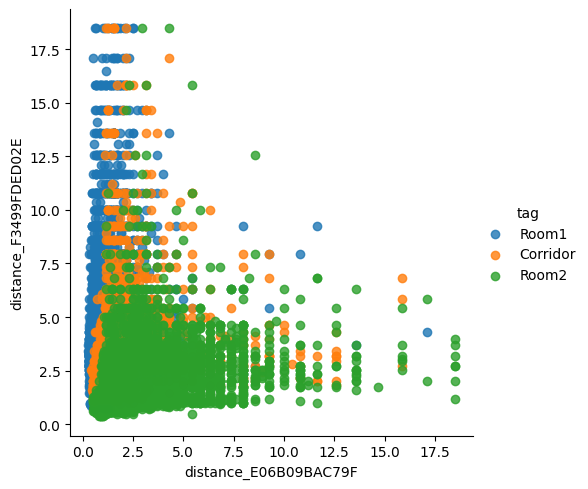

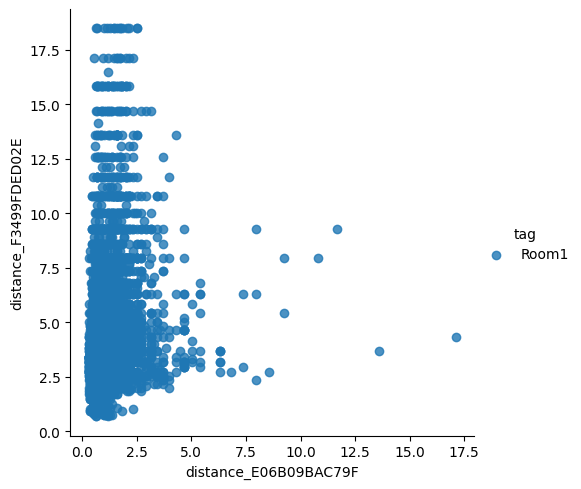

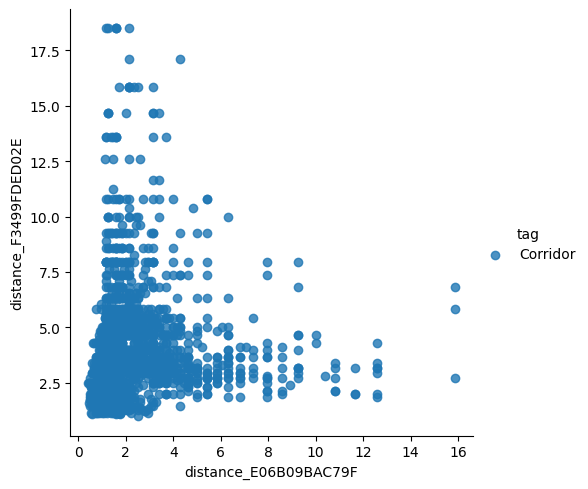

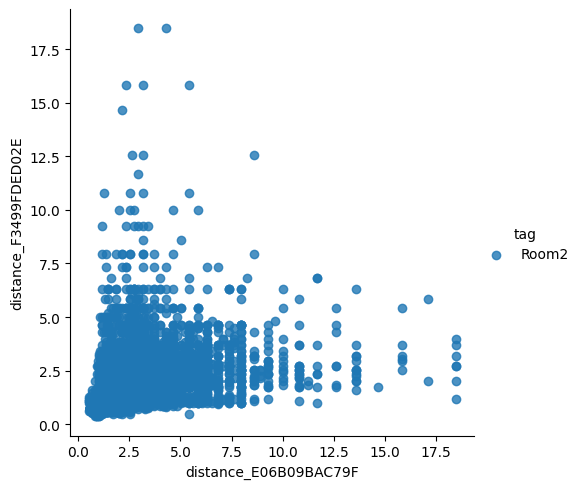

1072 - 100656666
2172 - 100029571
2154 - 1000454480
2158 - 1000411111
2172 - 100029586
1089 - 1230329194
2144 - 1000422222


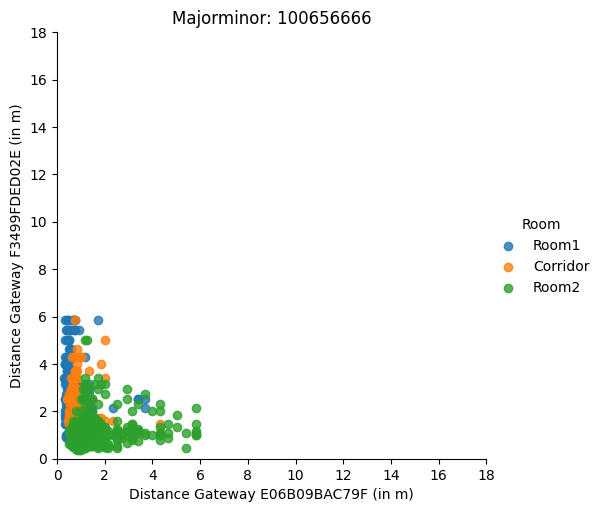

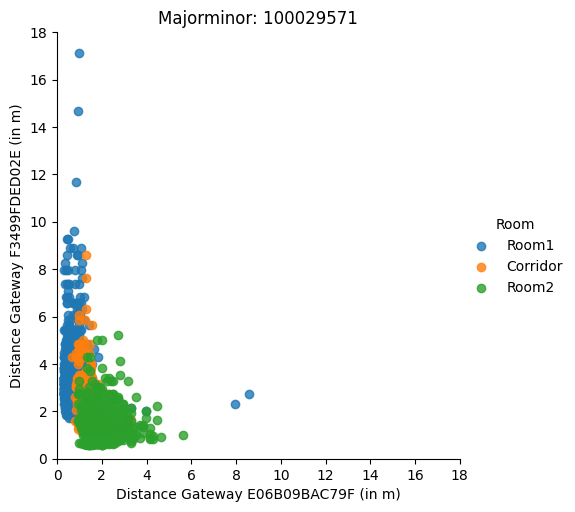

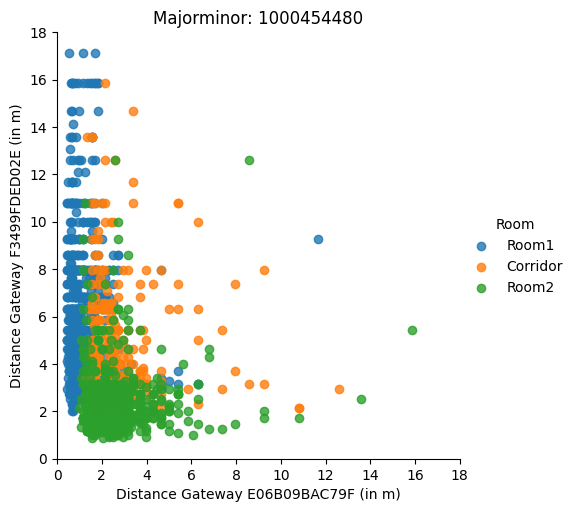

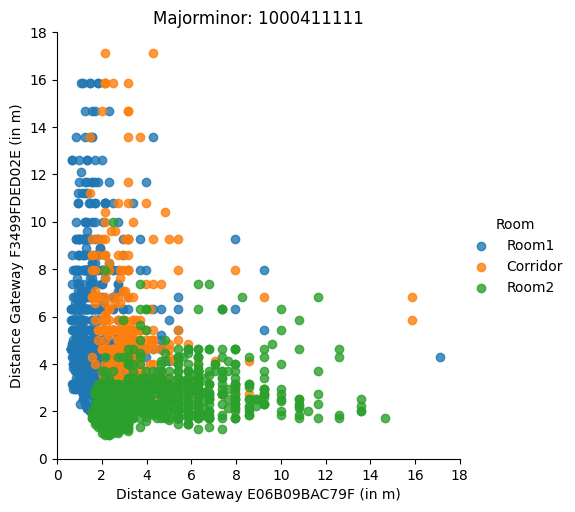

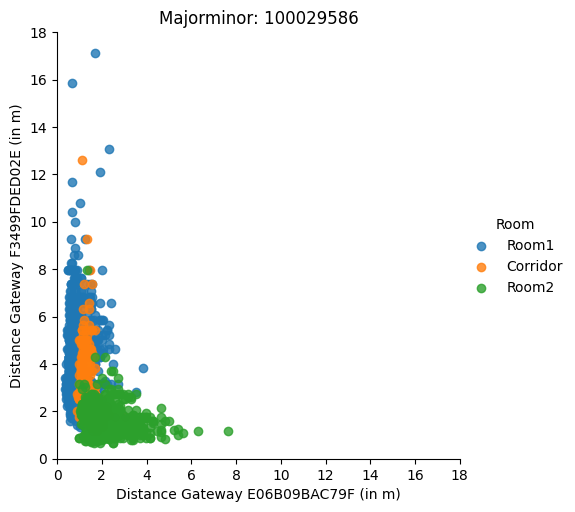

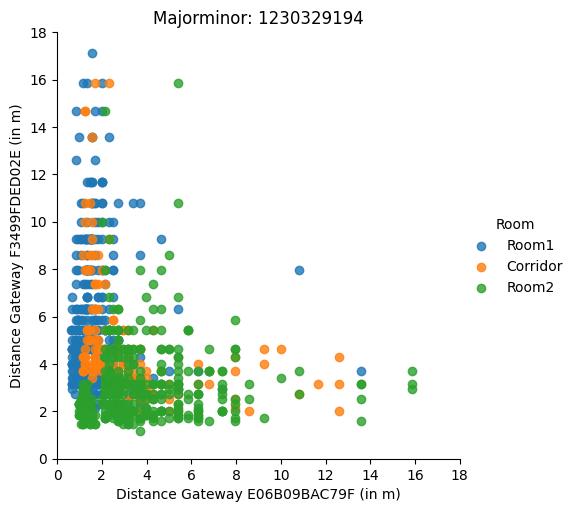

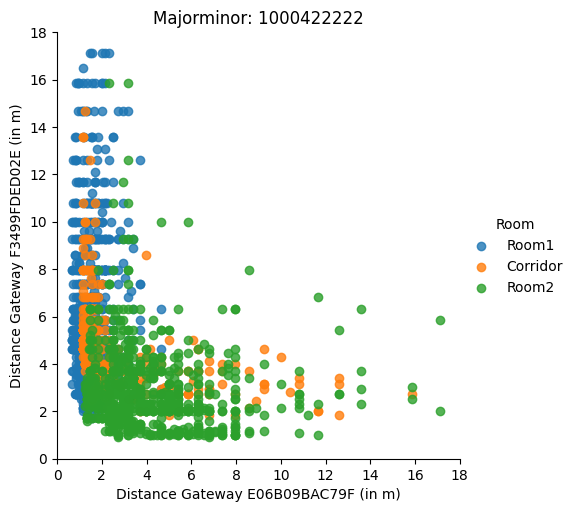

In [ ]:
##THIS PLOTS ARE CURRENTLY NOT REUQIRED AS WITH SEPERATION OF GATEWAYS THE
#ADDITIONAL INFORMATION OF DISTANCE AT A SPECIFIC TIMESTAMP AND THE VALUE OF 
#THE OTHER GATEWAY GIVES NO BENEFIT FOR INITIAL ANALYSATION 

#Selects all columns that start with distance
distance_column_names = [column for column in adapted_master_df.columns if column.startswith('distance')]

x_label_str = str(distance_column_names[0].split('_')[1])
y_label_str = str(distance_column_names[1].split('_')[1])

sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=adapted_master_df, hue='tag', fit_reg=False)
for tag in adapted_master_df.tag.unique():
  sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=adapted_master_df.loc[adapted_master_df.tag==tag], hue='tag', fit_reg=False)

plt.show()

for majorminor in adapted_master_df.majorminor.unique():
  df = adapted_master_df.loc[adapted_master_df.majorminor == majorminor]
  ax = sns.lmplot(x=distance_column_names[0], y=distance_column_names[1], data=df, hue='tag', fit_reg=False)
  
  ax.set(xlabel=f'Distance Gateway {x_label_str} (in m)',
         ylabel=f'Distance Gateway {y_label_str} (in m)')
  print(f'{len(df)} - {majorminor}')
  plt.title(f'Majorminor: {majorminor}')
  ax._legend.set_title('Room')
  ax.set(xlim=(0,18), ylim=(0, 18))

  
plt.show()
#for tag in adapted_master_df.tag.unique():
#  df = adapted_master_df.loc[adapted_master_df.tag == tag]
#  sns.lmplot(x=rssi_column_names[0], y=rssi_column_names[1], data=df, hue='specificTag', fit_reg=False)
#  plt.show()

##Aktuelle Plots für Analyse

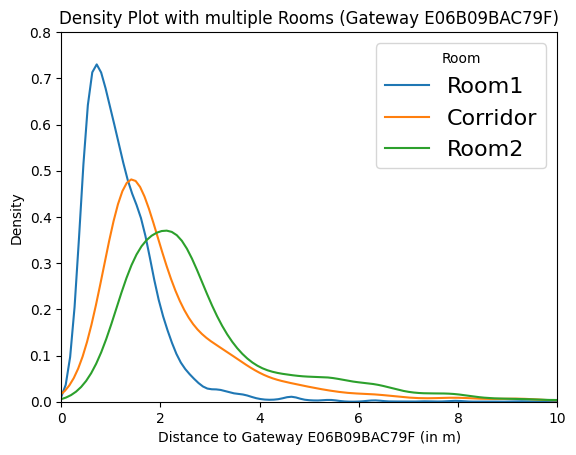

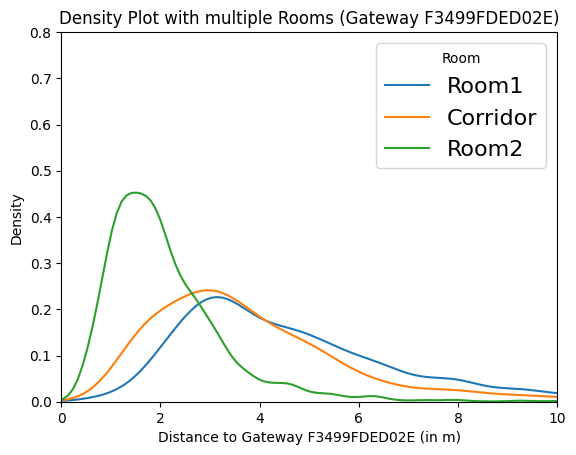

In [ ]:
#Gets all tags (can be modified to spefic tags etc)
tags = adapted_master_df.tag.unique()
#Selects all columns that start with distance
distance_column_names = [column for column in adapted_master_df.columns if column.startswith('distance')]

for distance_column in distance_column_names:
  gateway = str(distance_column.split('_')[1])
  #Iterates through the tags
  for tag in tags:
    #Subset to the specific tag
    subset = adapted_master_df[adapted_master_df['tag'] == tag]
    
    #Draw density plot
    ax = sns.kdeplot(subset[distance_column], label = tag)

    ax.set(xlabel=f'Distance Gateway {gateway} (in m)')
    ax.set(xlim=(0,10), ylim=(0, 0.8))
    
  #Plot formatting
  plt.legend(prop={'size': 16}, title = 'Room')
  plt.title(f'Density Plot with multiple Rooms (Gateway {gateway})')
  plt.xlabel(f'Distance to Gateway {gateway} (in m)')
  plt.ylabel('Density')
  plt.show()

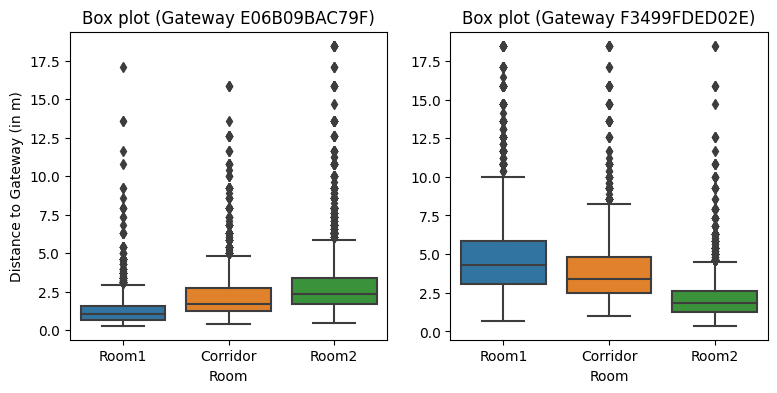

In [ ]:
#Box plot for each Gateway
distance_column_names = [column for column in adapted_master_df.columns if column.startswith('distance')]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

for index, distance_column in enumerate(distance_column_names):  
  gateway = distance_column.split('_')[1]

  #Plot box plot
  sns.boxplot(ax=axs[index], x='tag', y=distance_column, data=adapted_master_df)
  axs[index].set_title(f'Box plot (Gateway {gateway})')
  #Plot Y-Label just for first plot
  if index > 0:
    axs[index].set(xlabel='Room',
                   ylabel='')
  else:
    axs[index].set(xlabel='Room',
                   ylabel='Distance to Gateway (in m)')

plt.show()

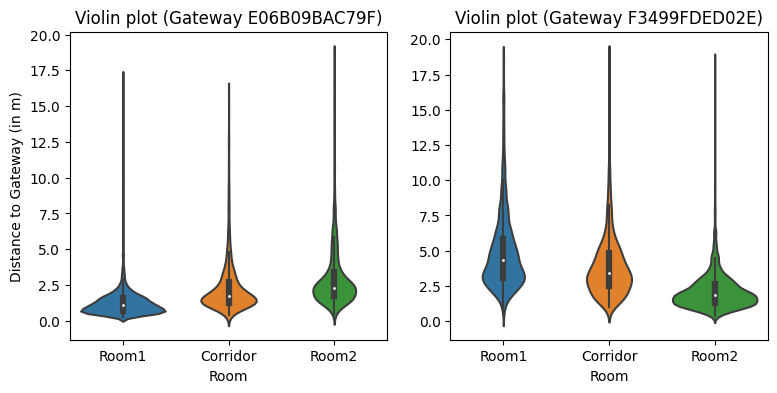

In [ ]:
#Violin plot for each gateway
distance_column_names = [column for column in adapted_master_df.columns if column.startswith('distance')]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

for index, distance_column in enumerate(distance_column_names):  
  gateway = distance_column.split('_')[1]

  #Plot violin plot
  asdf = sns.violinplot(ax=axs[index], x='tag', y=distance_column, data=adapted_master_df)
  axs[index].set_title(f'Violin plot (Gateway {gateway})')
  #Plot Y-Label just for first plot
  if index > 0:
    axs[index].set(xlabel='Room',
                   ylabel='')
  else:
    axs[index].set(xlabel='Room',
                   ylabel='Distance to Gateway (in m)')
plt.show()

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


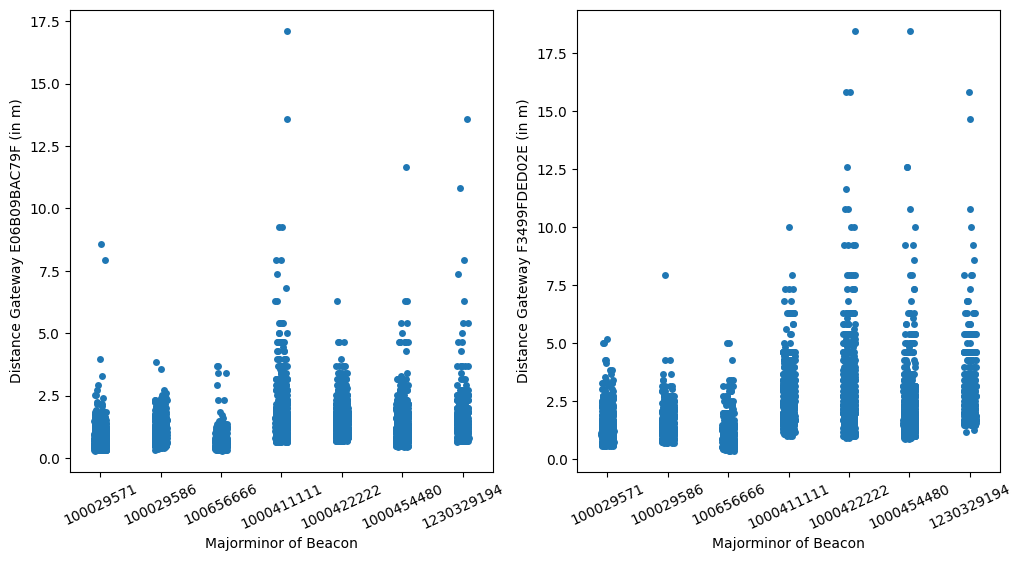

In [ ]:
#Shows range of values for each beacon for each gateway and it's specific allocated room

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

df = adapted_master_df.loc[(adapted_master_df.tag == "Room1") & (adapted_master_df.gateway_E06B09BAC79F == "E06B09BAC79F")]

axs[0] = sns.stripplot(ax=axs[0], x="majorminor", y="distance_E06B09BAC79F", data=df)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=25)
axs[0].set(xlabel='Majorminor of Beacon',
           ylabel='Distance Gateway E06B09BAC79F (in m)')

df = adapted_master_df.loc[(adapted_master_df.tag == "Room2") & (adapted_master_df.gateway_F3499FDED02E == "F3499FDED02E")]

axs[1] = sns.stripplot(ax=axs[1], x="majorminor", y="distance_F3499FDED02E", data=df)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=25)
axs[1].set(xlabel='Majorminor of Beacon',
           ylabel='Distance Gateway F3499FDED02E (in m)')
plt.show()

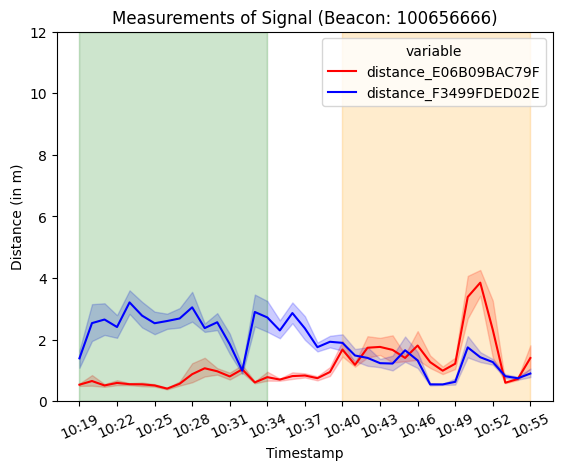

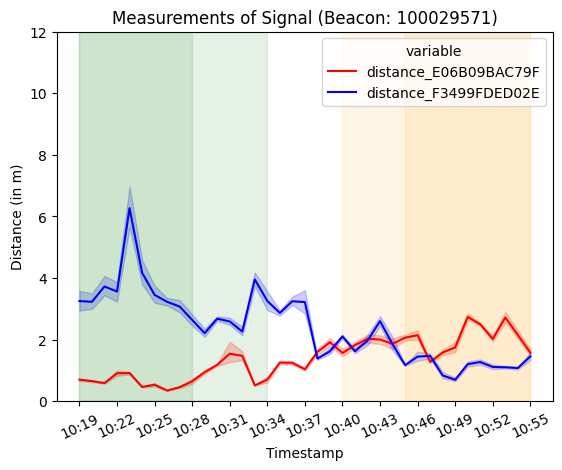

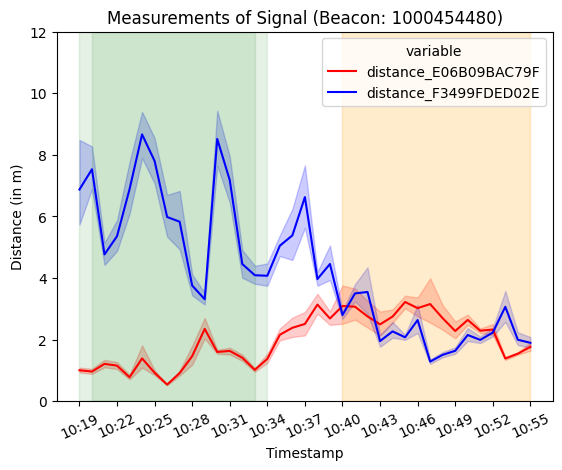

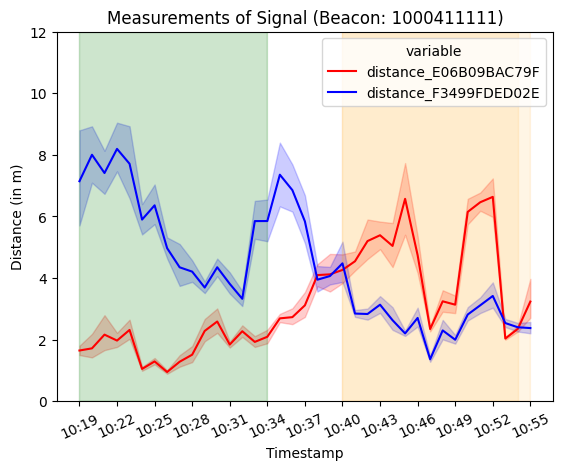

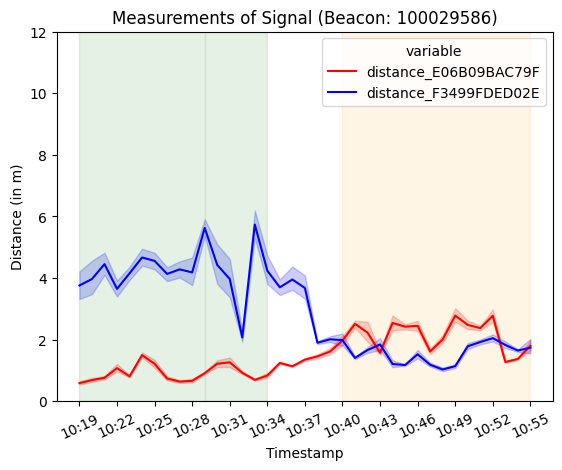

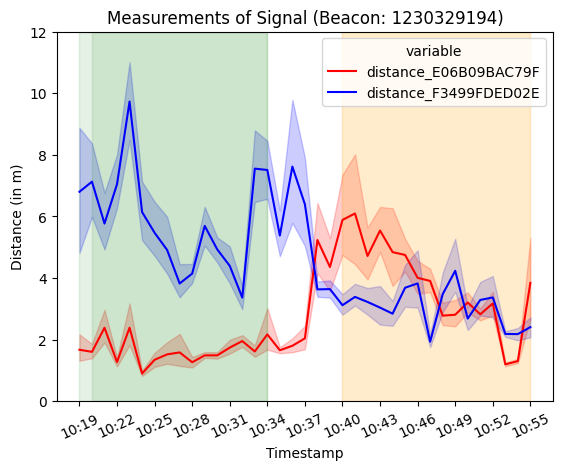

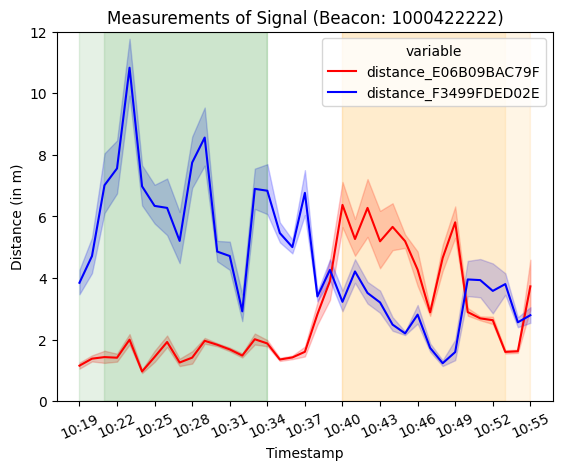

In [ ]:

for majorminor in adapted_master_df.majorminor.unique():
  df = adapted_master_df.loc[adapted_master_df.majorminor == majorminor,(distance_column_names + ['timestamp'])]

  #Preparation for fill between values to show which measurement belongs to which room
  room1_start_timestamp = df.timestamp.min()
  room1_start_time = pd.to_datetime(room1_start_timestamp,unit='s').strftime('%H:%M')
  #5 measures a 3 minutes in room1 added to starttimestamp to get endtimestamp (60 is used for convertion to seconds)
  room1_end_timestamp = room1_start_timestamp + 5*3*60
  room1_end_time = pd.to_datetime(room1_end_timestamp,unit='s').strftime('%H:%M')
  #2 measures a 3 minutes in corridor (added to end timestamp of room1 to get starttime of room2)
  room2_start_timestamp = room1_end_timestamp + 2*3*60
  room2_start_time = pd.to_datetime(room2_start_timestamp,unit='s').strftime('%H:%M')
  #5 measures a 3 minutes in room2 added to starttimestamp to get endtimestamp (60 is used for convertion to seconds)
  room2_end_timestamp = room2_start_timestamp + 5*3*60
  room2_end_time = pd.to_datetime(room2_end_timestamp,unit='s').strftime('%H:%M')

  #Convertion of timestamp to datetime in hours and minutes for plot readability
  df.timestamp = pd.to_datetime(df.timestamp,unit='s').dt.strftime('%H:%M')

  #Melt of dataframe for easy plotting preparation
  melted_df = pd.melt(df, ['timestamp'])

  ax = sns.lineplot(x='timestamp', y='value', hue='variable', 
                    data=melted_df,
                    palette=['red', 'blue'])
                    #estimator='median')
                      
  ax.set(xlabel='Timestamp',
         ylabel='Distance (in m)',
         ylim=[0,12])

  #Adaptation of x label frequency to 3 minutes itteration for readability of visualisation
  ax.set_xticks(ax.get_xticks()[::3])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25)

  #Filling for Room1
  ax.fill_between(melted_df.timestamp, 0,1, where=((melted_df.timestamp >= room1_start_time) & (melted_df.timestamp <= room1_end_time)),
                  color='green', alpha=0.05, transform=ax.get_xaxis_transform())

  #Filling for Room2
  ax.fill_between(melted_df.timestamp, 0,1, where=((melted_df.timestamp >= room2_start_time) & (melted_df.timestamp <= room2_end_time)),
                  color='orange', alpha=0.05, transform=ax.get_xaxis_transform())

  
  plt.title(f'Measurements of Signal (Beacon: {majorminor})')
  plt.show()

#Dateneinlesen und -grobaufbereitung
In diesem Abschnitt werden die Daten so aufbereitet, dass diese auf die Modelle angewendet werden können. Sowohl als Trainings- und Testdaten.  

In [ ]:
majorminor_to_beacon_model = {100029571:'K8', 100029586: 'K8',
                              1000411111:'Axaet PC023',
                              1000422222:'Axaet PC038',
                              1000454480:'Axaet PC061',
                              100656666:'Feasy P103', 1230329194:'Feasy P103'}

majorminor_to_manufacturer = {100029571:'K8', 100029586: 'K8',
                              1000411111:'Axaet', 1000422222:'Axaet', 1000454480:'Axaet',
                              100656666:'Feasy', 1230329194:'Feasy'}

helper = pd.Series(np.unique(list(majorminor_to_beacon_model.values())))
code_to_beacon_model = dict(zip(helper,helper.astype("category").cat.codes))

helper = pd.Series(np.unique(list(majorminor_to_manufacturer.values())))
code_to_manufacturer = dict(zip(helper,helper.astype("category").cat.codes))

In [ ]:
def add_model_and_manufactorer_to_df(data_df):
  data_df['beacon_model'] = [code_to_beacon_model.get(majorminor_to_beacon_model.get(majorminor)) for majorminor in data_df.majorminor]
  data_df['manufacturer'] = [code_to_manufacturer.get(majorminor_to_manufacturer.get(majorminor)) for majorminor in data_df.majorminor]

  return data_df.copy()

In [ ]:
#Mapping used to adapt the current tags with new labels ('InRoom': True / False)
gateway_to_tag = {'E06B09BAC79F':'Room1', 'F3499FDED02E':'Room2'}

def extend_df_with_label(data_df):
  '''
  Gets dataframe and adds label to it.
  If df entry contains following values InRoom is set to 1:
  'E06B09BAC79F':'Room1' -> InRoom = 1
  'F3499FDED02E':'Room2' -> InRoom = 1
  Else -> InRoom = 0
  '''
  data_df.distance = data_df.distance.round(3)
  data_df['InRoom'] = [1 if (gateway_to_tag.get(gateway) == tag) else 0 for tag in data_df.tag]
  data_df = add_model_and_manufactorer_to_df(data_df)
  return data_df.copy()

In [ ]:
#Columns in CSV Files
#_id,distance,gateway,major,majorminor,minor,rssi,timestamp,beaconType,uuid
columns_of_interessts = ['distance','gateway','uuid','majorminor','timestamp','tag','specificTag']

#Create new master dicitonary seperated by gateways
master_dict = dict()

#Training
filepath = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Training/Set_3Min_Each_Point/LabeledCombinedGatewayData.csv'
#Test closed Doors
#filepath = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv'
#Test open Doors
#filepath = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv'

#Load and secure clean data
master_df = pd.read_csv(filepath).drop_duplicates().reset_index(drop=True)

#Load Gateways
gateways = master_df.gateway.unique()

for gateway in gateways:
  temp_df = master_df.loc[master_df.gateway == gateway].copy()
  master_dict[gateway] = {'data': pd.DataFrame()}
  master_dict[gateway]['data'] = extend_df_with_label(temp_df)

#Datenfilterung, -aufbereitung und non Machine Learning Ansatz
In diesem Bereich werden unterschiedliche Filter für die Datenaufbereitung genutzt und verglichen. Anhand diesen Filtern soll auch eine erste **non** Machine Learning Modell erstellt werden. Dies kann auch für die darauffolgenden Modellen als Benchmark verwendet werden.

In [ ]:
distance_raw = 'distance'
distance_moving_median = 'distance_MMedian'
distance_moving_mean = 'distance_MMean'
distance_wiener = 'distance_Wiener'
distance_kalman = 'distance_Kalman'

dict_filter_distance_columns = {'Raw':distance_raw, 'MMedian': distance_moving_median, 'MMean': distance_moving_mean,
                                'Wiener': distance_wiener, 'Kalman': distance_kalman}

In [ ]:
def extend_data_with_filtered_values(data_df, window_size=10):
  '''
  Gets dataframe and extends it with filter values (additional columns).
  The function is only used for analytical purposes as once optimal combinations are found
  filter should directly be applied to distance and no additional column is added to dataframe.
  @params window_size defines how many measurements are used for filter application (default 10)
  '''
  temp_df = data_df.copy()
  for majorminor in temp_df.majorminor.unique():
    distance = temp_df.loc[(temp_df.majorminor == majorminor)].distance
    #Moving Median filter
    array_distance_moving_median = distance.rolling(window=window_size,center=True).median().to_numpy()
    temp_df.loc[(temp_df.majorminor == majorminor), distance_moving_median] = array_distance_moving_median.round(3)
    #Sliding Window / moving mean filter
    array_distance_moving_mean = distance.rolling(window=window_size,center=True).mean().to_numpy()
    temp_df.loc[(temp_df.majorminor == majorminor), distance_moving_mean] = array_distance_moving_mean.round(3)
  
    #Wiener Filter
    array_distance_wiener = wiener(distance.to_numpy(),mysize=window_size)
    temp_df.loc[(temp_df.majorminor == majorminor), distance_wiener] = array_distance_wiener.round(3)
  
    #Kalman filter
    #Uses standard setting and EM algorithmen to optimize em variables such as via .em function
    #transition_covariance, observation_covariance, initial_state_mean and initial_state_covariance
    kf = KalmanFilter()
    #n_iter prevents overfitting of EM fitting and smooth predicts rssi values
    #[0][:,0] selects the predicted rssi values of the returned array
    array_distance_kalman = kf.em(distance, n_iter=5).smooth(distance)[0][:,0]
    temp_df.loc[(temp_df.majorminor == majorminor), distance_kalman] = array_distance_kalman.round(3)
  return temp_df

In [ ]:
for gateway in master_dict.keys():
  master_dict[gateway]['data'] = extend_data_with_filtered_values(data_df = master_dict[gateway]['data'])

divide by zero encountered in true_divide


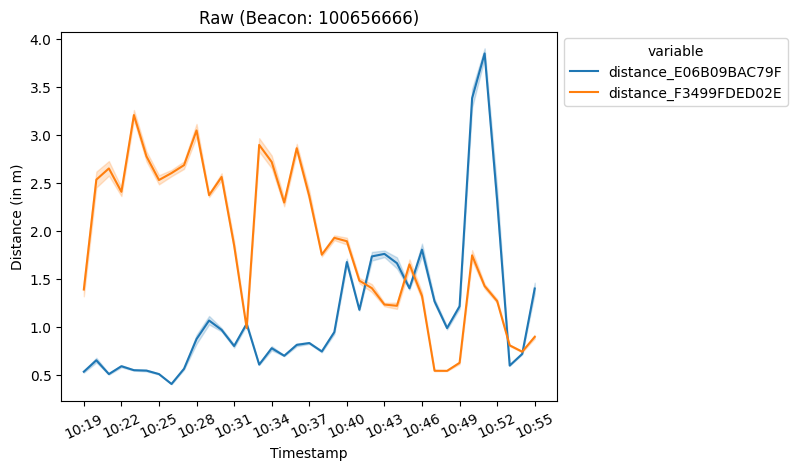

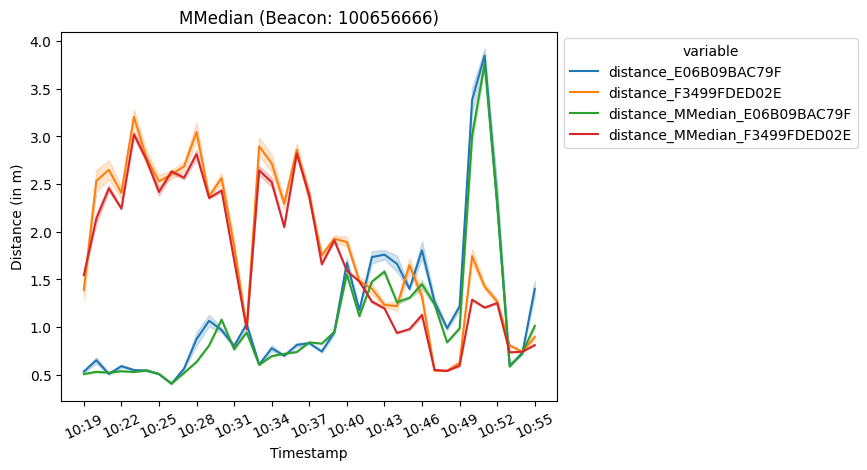

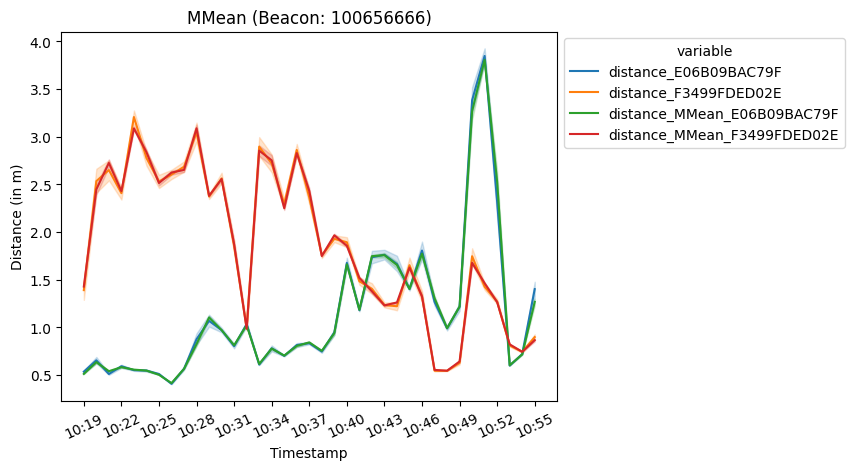

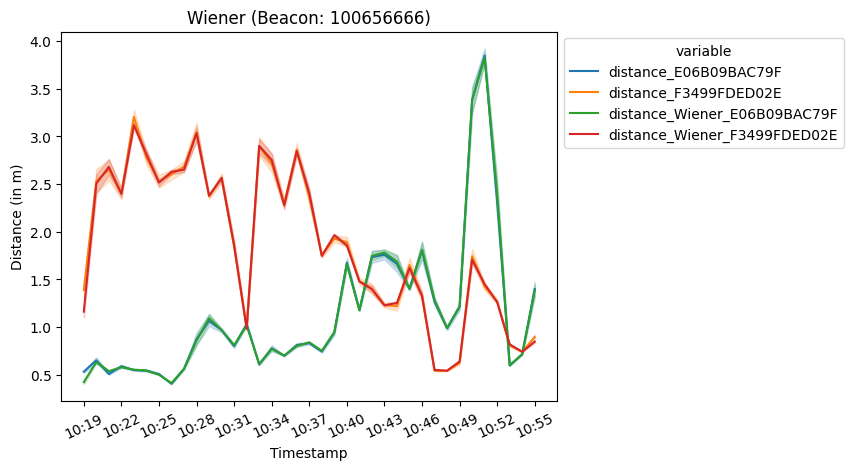

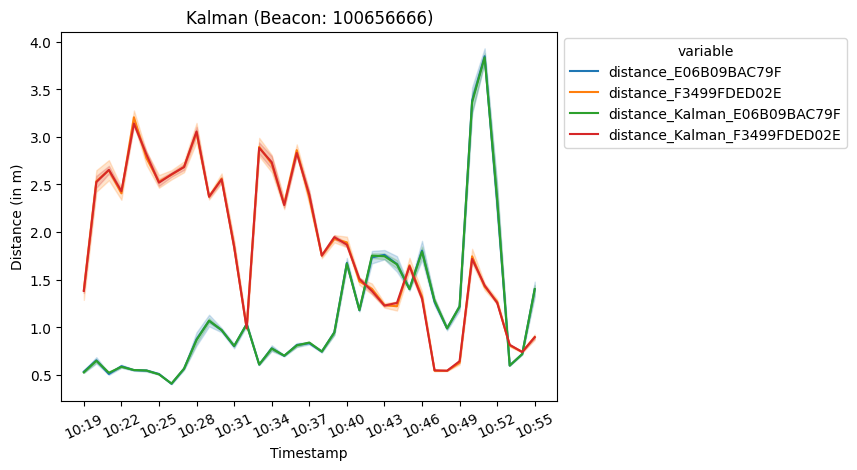

In [ ]:
#Important currently just plotted for first majorminor entry (see line with filteredDf.loc for this)
selected_majorminor = master_df.majorminor.unique()[0]

for filter in dict_filter_distance_columns.keys():
  #Predefine column selection for plots
  column_selection = ['distance'] + [dict_filter_distance_columns.get(filter)] + ['timestamp']
  df = pd.DataFrame(columns=column_selection)
  for gateway in master_dict.keys():
    #Load data
    temp_df = master_dict.get(gateway).get('data').copy()
    #Reducing entry for specified majorminor and columns
    temp_df = temp_df.loc[temp_df.majorminor == selected_majorminor,column_selection]
    #Casting timestamp to a certain format for illustration
    temp_df.timestamp = pd.to_datetime(temp_df.timestamp,unit='s').dt.strftime('%H:%M')
    #Preparation for different naming in plot
    temp_df = temp_df.rename(columns={c: f'{c}_{gateway}' for c in temp_df.columns if c.startswith('distance')})
    if len(df) > 0:
      df = pd.merge(temp_df, df,on=['timestamp'],how='outer')
    else:
      df = temp_df
  #Used for df mutation for direct polting
  df = pd.melt(df, ['timestamp']).sort_values(['timestamp','variable'])
  ax = sns.lineplot(x='timestamp', y='value', hue='variable', 
                    data=df)
  #Setting three minutes jumps in timestamp and other stylings on x-axies 
  ax.set_xticks(ax.get_xticks()[::3])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
  ax.set(xlabel='Timestamp',
         ylabel='Distance (in m)')

  plt.title(f'{filter} (Beacon: {selected_majorminor})')
  sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
  plt.show()


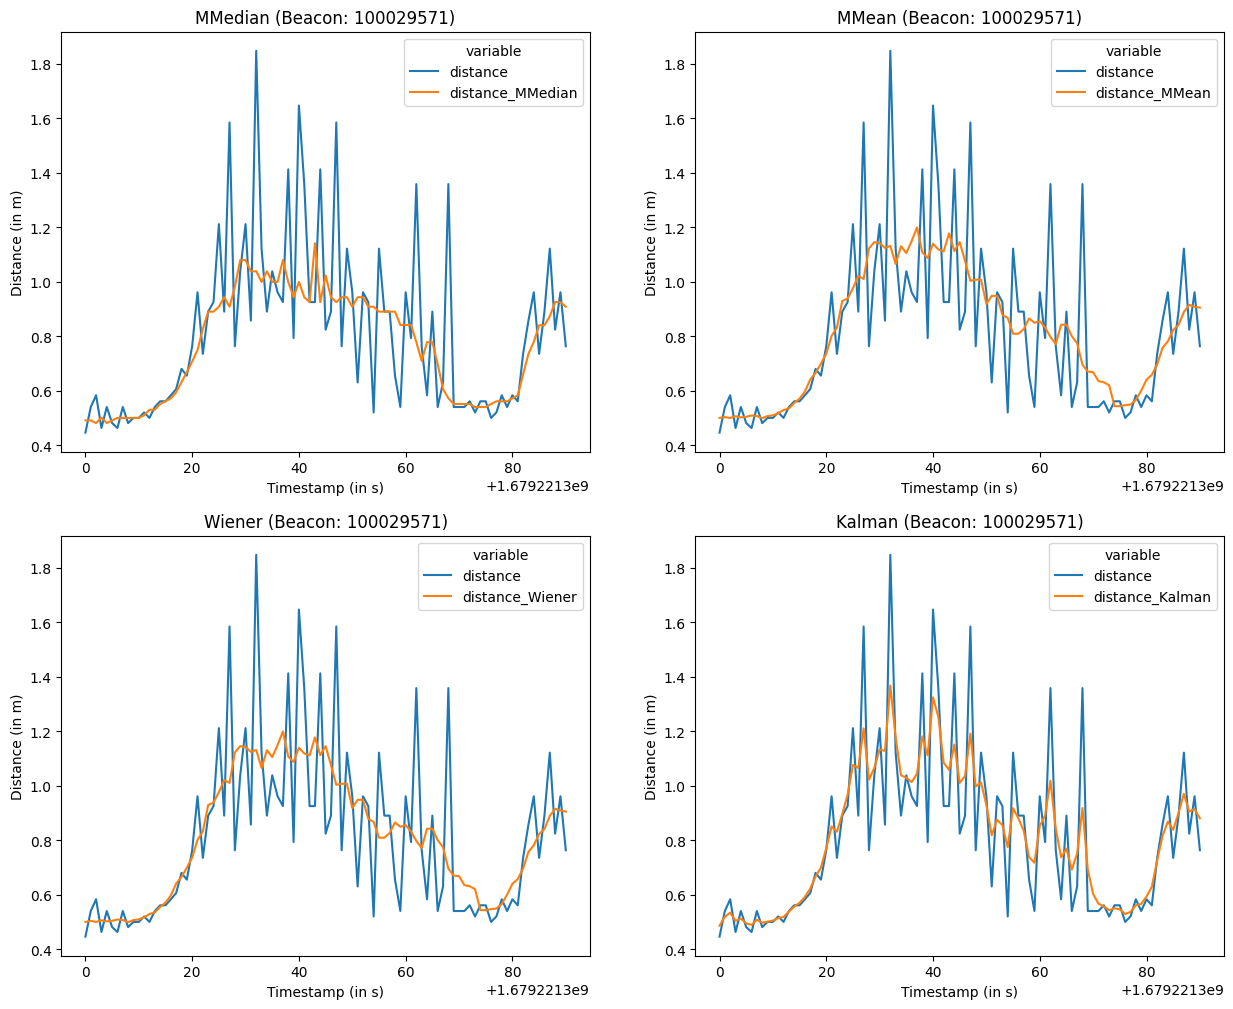

In [ ]:
#Create plot and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

#Important currently just plotted for first majorminor entry (see line with filteredDf.loc for this)
selected_majorminor = master_df.majorminor.unique()[1]
row_index = 0
col_index = 0

for filter in dict_filter_distance_columns.keys():
  if filter == 'Raw':
    continue
  
  if col_index / 2 >= 1:
    col_index = 0
    row_index += 1
  
  #Predefine column selection for plots
  column_distance_selection = ['distance'] + [dict_filter_distance_columns.get(filter)]
  column_selection = column_distance_selection + ['timestamp']
  df = pd.DataFrame(columns=column_selection)
  #Plot is for visualisation purposes and just a single gateway signal is required
  gateway = list(master_dict.keys())[0]

  #Load data
  temp_df = master_dict.get(gateway).get('data').copy()
  #Start time for analyisation (1 Minute after first timestamp)
  mintime = temp_df.timestamp.min() + 120

  maxtime = mintime + 90
  #Reducing entry for specified majorminor and columns
  temp_df = temp_df.loc[temp_df.majorminor == selected_majorminor,column_selection]
  temp_df = temp_df.loc[(temp_df.timestamp >= mintime) & (temp_df.timestamp <= maxtime)]

  df = pd.melt(temp_df, ['timestamp']).sort_values(['timestamp','variable'])
  axs[row_index,col_index] = sns.lineplot(x='timestamp', y='value', hue='variable', 
                            data=df, ax=axs[row_index,col_index])

  axs[row_index,col_index].set(xlabel='Timestamp (in s)',
                 ylabel='Distance (in m)')
  axs[row_index,col_index].set_title(f'{filter} (Beacon: {selected_majorminor})')
  col_index += 1

plt.show()

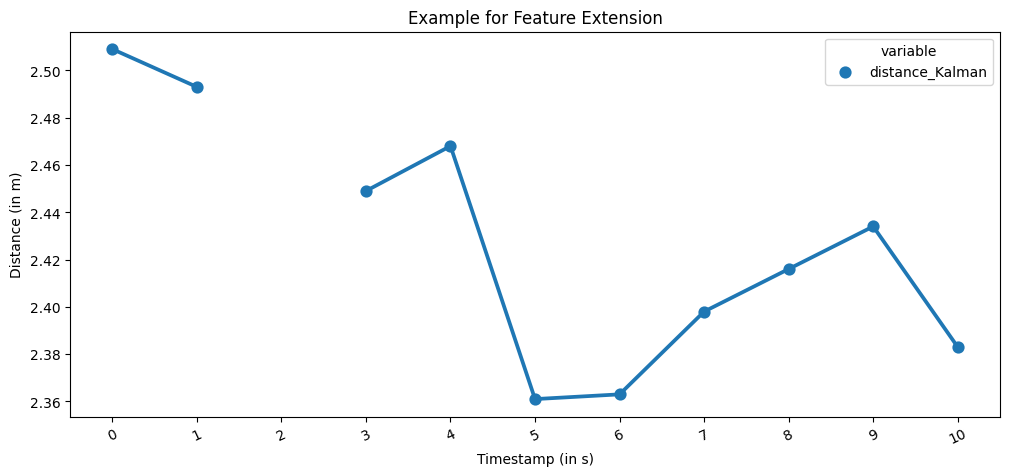

<Figure size 2000x400 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(figsize=(12,5))

#Important currently just plotted for first majorminor entry (see line with filteredDf.loc for this)
selected_majorminor = master_df.majorminor.unique()[1]
  
#Predefine column selection for plots
column_distance_selection = ['distance_Kalman']
column_selection = column_distance_selection + ['timestamp']
df = pd.DataFrame(columns=column_selection)
#Plot is for visualisation purposes and just a single gateway signal is required
gateway = list(master_dict.keys())[0]

#Load data
temp_df = master_dict.get(gateway).get('data').copy()
#Start time for analyisation (1 Minute after first timestamp)
mintime = temp_df.timestamp.min() + 1920

maxtime = mintime + 10
#Reducing entry for specified majorminor and columns
temp_df = temp_df.loc[temp_df.majorminor == selected_majorminor,column_selection]
temp_df = temp_df.loc[(temp_df.timestamp >= mintime) & (temp_df.timestamp <= maxtime)]

temp_df['timestamp'] = temp_df.timestamp - mintime
temp_df.loc[temp_df.timestamp == 2,['distance_Kalman']] = np.nan
df = pd.melt(temp_df, ['timestamp']).sort_values(['timestamp','variable'])
ax = sns.pointplot(x='timestamp', y='value', hue='variable', data=df, ax=axs)

#Setting three minutes jumps in timestamp and other stylings on x-axies 
ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
ax.set(xlabel='Timestamp (in s)',
       ylabel='Distance (in m)')

plt.title(f'Example for Feature Extension')
plt.figure(figsize=(20,4))

plt.show()

#Featureerweiterung (Feature Extraction)
In diesem Abschnitt werden aus den bestehenden Daten Features generiert. Dies soll ermöglichen, dass nicht nur ein Distanzeintrag an das Modell gesendet wird. So wird die Featureanzahl von 1 auf n erhöht.
Dabei werden verschiedene Anzahlen an zusätzlichen Features ausgetestet.

In [ ]:
#enlargement_size defines amount of additional feature values
#IMPORTANT 6 should be used as upper limit or otherwise with the current 
#dataset for training the number of datapoints has to be reduced
#Problem is, that knn distance calculation gets to complex, requires to much computing
#power (speifically RAM) which can lead to crash of the virtual google colab environmenet or
#index out of bound messages which lead to model performances of NAN as calculation gets aborted

def generate_df_with_additional_features(data_df, enlargement_size = 6):
  '''
  Requires a dataframe with distance values, timestamp and majorminor.
  It extends it with additional features.
  The additional features are the n previous measurements of the same majorminor value.
  @param enlargement_size defines how many previous measurements are added as additional feature default value is 6 
  (IMPORTANT enlargement size extends number of features by 2 times its size as previous distance and timedifference is added)
  '''
  additonal_cols = []
  timediff_cols = []
  feature_cols = list(dict_filter_distance_columns.values())
  for index in range(enlargement_size,0,-1):
    additonal_cols = additonal_cols + [f'{sub}-prev{index}' for sub in feature_cols]
    timediff_cols = timediff_cols + [f'timediff-prev{index}']

  new_df = pd.DataFrame()

  for majorminor in data_df.majorminor.unique():

    #Selects each beacon seperatly for clean data preparation
    temp_df = data_df.loc[data_df.majorminor == majorminor].copy().reset_index(drop=True)

    #Defines boundries for clean iteration through current dataframe
    lower_boundry = enlargement_size
    upper_boundry = len(temp_df)
    
    #Loops through whole dataset to add features
    for current_pos_index in range(lower_boundry,upper_boundry):
      ref_timestamp = temp_df.iloc[current_pos_index].timestamp
      ref_in_room = temp_df.iloc[current_pos_index].InRoom

      #Selects the n (enlargement_size) previous df entries before the current df entry
      df_section = temp_df.iloc[(current_pos_index - enlargement_size) : current_pos_index]

      #If Label InRoom is NOT the same it should lead to a sum of more than 0
      #in this case current iteration is skipped as it can not be used for training
      #Training should just contain previous data of the same label value
      if sum(df_section.InRoom != ref_in_room) > 0:
        continue

      #Current timestamp gets substracted of each entry seperatly
      timediffs = df_section.timestamp - ref_timestamp
      additional_features = df_section.loc[:,feature_cols]

      #Useage of col order and array transforming (reshaping) for direct assigning of values
      #As it is set for a single df entry shape has to be (n,1)
      temp_df.loc[temp_df.index == current_pos_index,timediff_cols] = timediffs.to_numpy().T
      temp_df.loc[temp_df.index == current_pos_index,additonal_cols] = additional_features.to_numpy().reshape(len(additonal_cols))       
        

      ##'Simpler' solution but extremly imperformant
      ##Above solution is 7 times faster

      #for index in range(1,enlargement_size+1):
        
      #  additional_features_index = current_pos_index - index
        #Abort current iteration as it should just use reference points within same label (InRoom)
      #  if (ref_in_room != temp_df.iloc[additional_features_index].InRoom):
      #    continue
      #  timediff = temp_df.iloc[additional_features_index].timestamp - ref_timestamp
        
      #  additonal_cols = [sub +'-prev'+str(index) for sub in feature_cols]
      #  distances = temp_df.loc[temp_df.index == additional_features_index,feature_cols]

      #  temp_df.loc[temp_df.index == current_pos_index,additonal_cols] = distances.to_numpy()
      #  temp_df.loc[temp_df.index == current_pos_index,['timediff-prev'+str(index)]] = timediff

    #Cleans df and drops all rows which contain a single nan value
    temp_df = temp_df.dropna()
    #Checks if df has already entries and has to be concated with them or new assigned
    if len(new_df) > 0:  
      new_df = pd.concat([new_df, temp_df], ignore_index=True)
    else:
      new_df = temp_df.copy()
  return new_df.copy()

In [ ]:
for gateway in master_dict.keys():
  df = master_dict.get(gateway).get('data')
  master_dict[gateway]['extended_data'] = generate_df_with_additional_features(data_df = df)

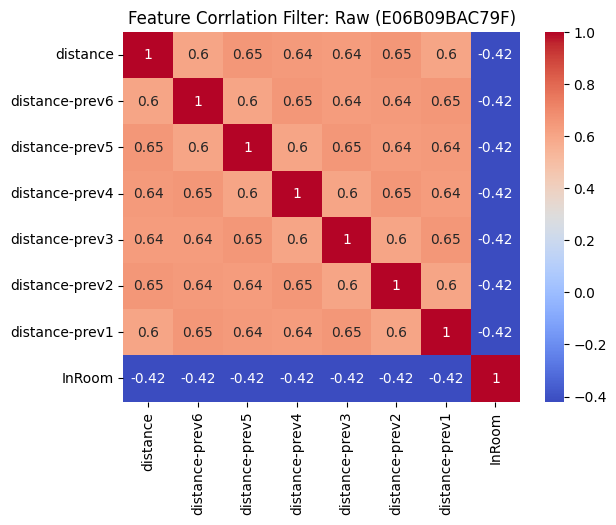

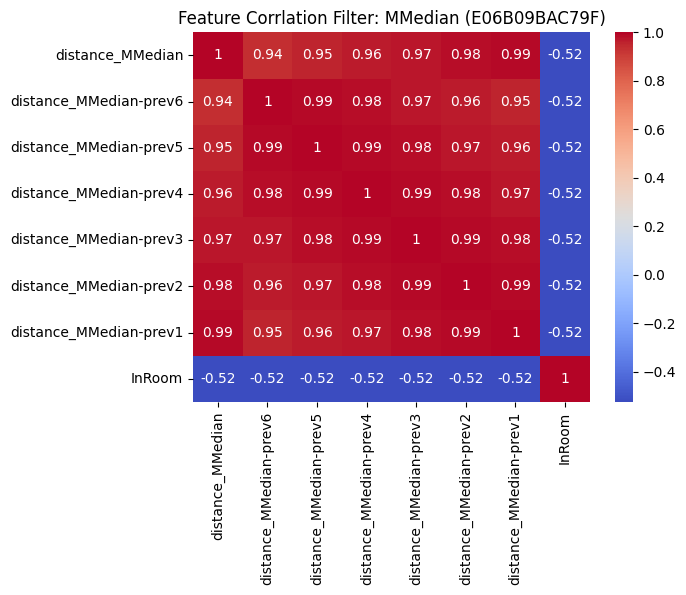

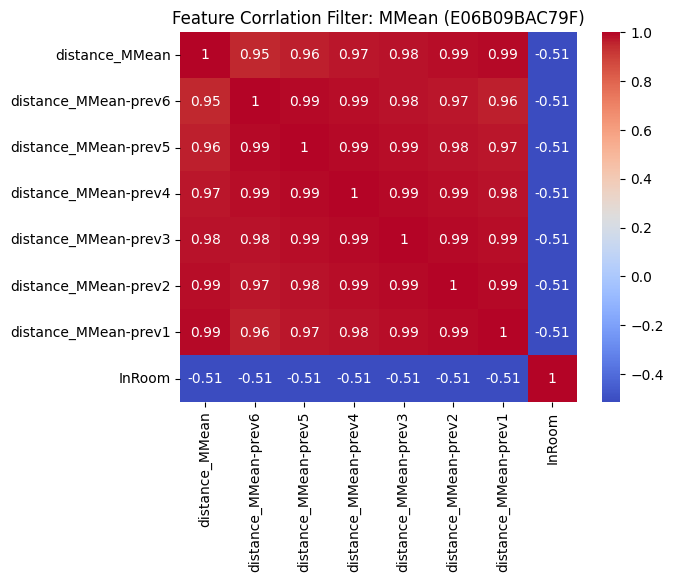

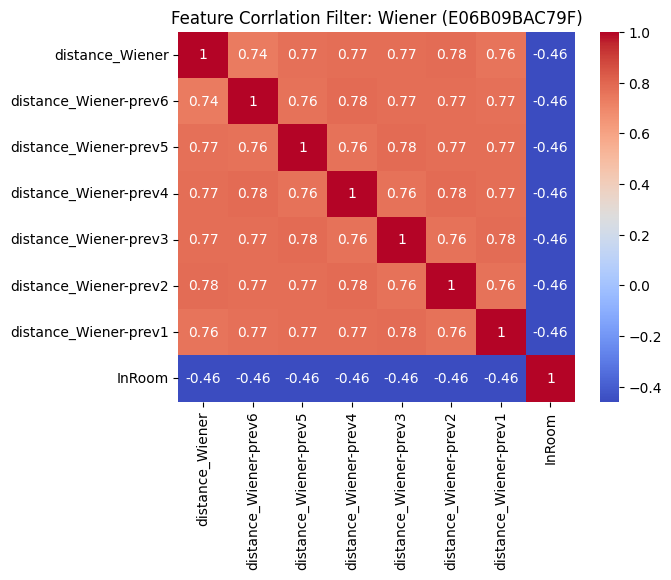

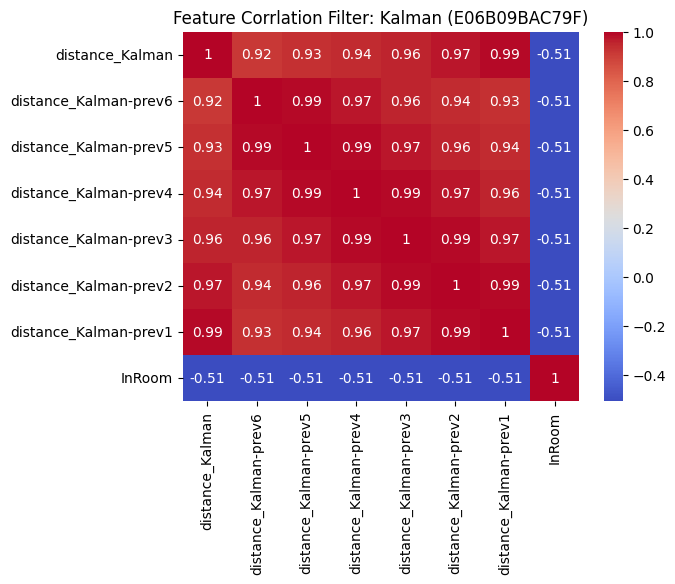

In [ ]:
gateway = list(master_dict.keys())[0]
df = master_dict.get(gateway).get('extended_data').copy()

for filter in dict_filter_distance_columns.keys():

  prefix = dict_filter_distance_columns.get(filter)
  column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-'))]
  column_selection = column_selection + ['InRoom']
  
  temp_df = df.loc[:,column_selection]
  plt.figure()
  sns.heatmap(temp_df.corr(), cmap='coolwarm', annot=True)
  plt.title(f'Feature Corrlation Filter: {filter} ({gateway})')
  plt.show()

#Machine Learning Algorithmen Training / Hyperparameter Tuning  (Optional)
Beinhaltet die unterschiedlichen Machine Learning Ansätze, welche auf die Trainingsdatensätze Hyperparameter Tuning durchgeführt wird.

KNN, Naive Bayes, Support Vector Classifier (SVC), Random Forest Classifier und XGBoost

In [ ]:
#Set answer to every question as random state (as it is a number used for randomization)
#Seed can be set to any number but if the same number is used it can ensure that 
#randomness leads to the same behaviour when executed multiple times
random_state=42
dict_best_accuracy = dict.fromkeys(master_dict.keys(), {})

##Nearest Neighbors Classifier

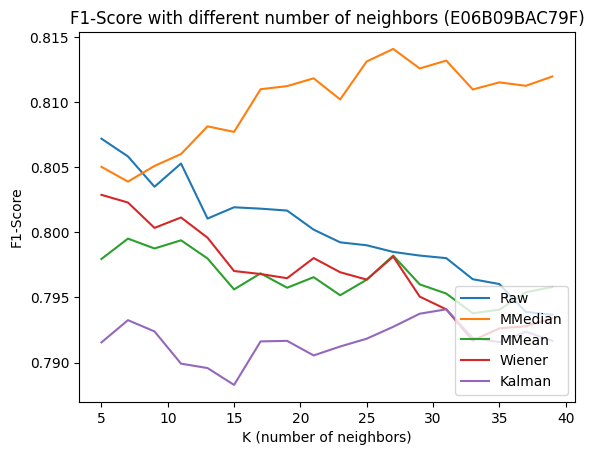

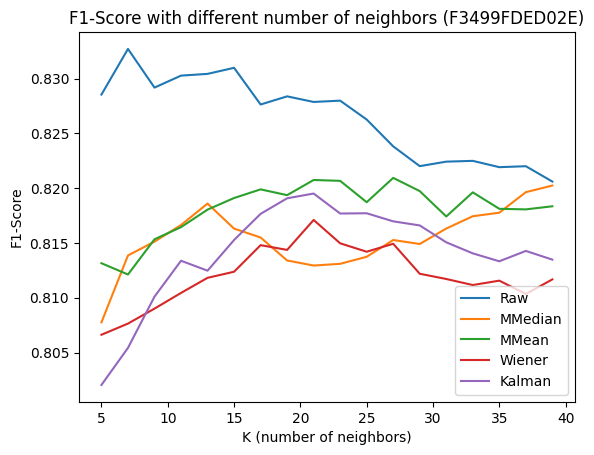

In [ ]:
model_type = 'knn'

for gateway in master_dict.keys():
  #Loads limited amount of data due to errors (Session break downs and nan scoring values)
  #Required if additional feature extends 6 
  df = master_dict.get(gateway).get('extended_data')#.sample(20000,random_state=random_state)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_accuracy = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  k = []

  #Check different number of neighbors
  for n_neighbors in range(5, 40, 2):
    #Use a nearest neighbor classifier to evaluate the methods
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    k.append(n_neighbors)

    for filter in dict_filter_distance_columns.keys():
      prefix = dict_filter_distance_columns.get(filter)
      column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]

      X = df.loc[:,column_selection]
      Y = df.InRoom

      #Ensures that folds are shuffled to prevent overfitting
      kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)

      #Calculates cross validation score 
      crossv_results = cross_val_score(knn, X, Y, cv=kfold, scoring='f1_weighted')

      #Append score to list categorised by filter for easy plotting
      dict_accuracy[filter] = dict_accuracy.get(filter) + [crossv_results.mean()]

      #Checks if the current k for the knn model with the given data (provided by a certain gateway and applied filter) is better than the previous model performance
      #if this is the case the current settings overwrite the previous settings
      if (len(dict_best_accuracy[gateway][model_type][filter])==0) or (dict_best_accuracy[gateway][model_type][filter]['best_score_'] < [crossv_results.mean()]) :
        dict_best_accuracy[gateway][model_type][filter] = {'best_score_': crossv_results.mean(),
                                    'best_params_': {'n_neighbors': n_neighbors}}
  #Used for ploting a graph which shows the performance of the models
  #depending on number of neighbors with the given training / test data
  for key in dict_accuracy.keys():
    plt.plot(k, dict_accuracy[key])
  plt.ylabel('F1-Score')
  plt.xlabel('K (number of neighbors)')
  plt.legend(dict_accuracy.keys(), loc='lower right')
  plt.title(f'F1-Score with different number of neighbors ({gateway})')
  plt.show()

##Support Vector Classification (SVC)

In [ ]:
model_type = 'svc'

#Define values of parameters to test for optimize model
#The reduced number of options in the parameters is due to several
#executions in which required options could be narrowed down
param_svc_grid = { 'C': [10, 100, 1000], 'gamma': [1, 0.1], 'kernel': ['rbf'] }

for gateway in master_dict.keys():
  #Loads data with additional features
  #Sample can be used if hypertuning time should be reduced (Could lead to not optimal hyperparameter)
  df = master_dict.get(gateway).get('extended_data')#.sample(8000,random_state=random_state)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

  #Create default instance of support vector classification model
  #Some default parameter values are changed in grid search further below by param_svc_grid above
  svc = SVC()

  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #sc = StandardScaler()
    #X = sc.fit_transform(X)
    
    #Ensures that folds are shuffled to prevent overfitting
    kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

    #GridSearch is used for extensively test hyperparameter settings
    #It returns the optimal setting grid but not a final model which can be stored
    #Therefore score and params gets saved in dictionary
    svc_grid = GridSearchCV(estimator=svc, param_grid=param_svc_grid, cv=kfold, scoring='f1_weighted')
    #RandomizedSearchCV(estimator=svm, param_grid=param_svc_grid, cv=kfold, random_state=random_state, n_iter=10)
    svc_grid.fit(X, Y)

    print(filter)
    print(svc_grid.best_score_)
    print(svc_grid.best_params_)
    dict_best_accuracy[gateway][model_type][filter] = {'best_score_': svc_grid.best_score_,
                                                       'best_params_': svc_grid.best_params_}

##Naive Bayes

In [ ]:
model_type = 'nbayes'

#Define values of parameters to test for optimize model
param_grid_nb = { 'var_smoothing': np.logspace(0,-9, num=100) }

for gateway in master_dict.keys():
  #Loads data with additional features
  df = master_dict.get(gateway).get('extended_data')

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

  #Create default instance of gaussian naive bayes classifier model
  #Some default parameter values are changed in grid search further below by param_grid_nb above
  gnb = GaussianNB()

  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
    column_selection += ['manufacturer']

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #Ensures that folds are shuffled to prevent overfitting
    kfold = KFold(n_splits=10, random_state=random_state, shuffle=True)

    #GridSearch is used for extensively test hyperparameter settings
    #It returns the optimal setting grid but not a final model which can be stored
    #Therefore score and params gets saved in dictionary
    gnb_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, cv=kfold, scoring='f1_weighted')
    gnb_grid.fit(X, Y)

    print(filter)
    print(gnb_grid.best_score_)
    print(gnb_grid.best_params_)
    dict_best_accuracy[gateway][model_type][filter] = {'best_score_': gnb_grid.best_score_,
                                                       'best_params_': gnb_grid.best_params_}

E06B09BAC79F
Raw
0.6864361548951814
{'var_smoothing': 0.0001519911082952933}
MMedian
0.742516442958369
{'var_smoothing': 0.0005336699231206307}
MMean
0.7202968593112583
{'var_smoothing': 4.328761281083062e-05}
Wiener
0.7135339399226408
{'var_smoothing': 1.5199110829529332e-05}
Kalman
0.721241616007469
{'var_smoothing': 0.0001}
F3499FDED02E
Raw
0.7423527416338767
{'var_smoothing': 0.0023101297000831605}
MMedian
0.7885031417542814
{'var_smoothing': 0.0001232846739442066}
MMean
0.7750208606049165
{'var_smoothing': 0.0001232846739442066}
Wiener
0.7691013041252373
{'var_smoothing': 0.0005336699231206307}
Kalman
0.7750501022059264
{'var_smoothing': 6.579332246575683e-05}


##Random Forest

In [ ]:
#Define space required for bayesian optimization (is an alternativ to GridSearchCV and RandomizedSearchCV)
#This approach as well as RandomizedSearchCV is usefull if number of possible params combination is high

#Number of trees in random forest that are used for estimation
n_estimators = range(100,501,100)
#Number of features to consider at every split
max_features = ['sqrt'] #Excluded 'auto' as it is deprecated in 1.1 and will be removed in 1.3
#Maximum number of levels in tree
max_depth = range(15,31,5)
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
#Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
#Method of selecting samples for training each tree
bootstrap = [True, False]

space_rforest = {
    'n_estimators': hp.choice('n_estimators', n_estimators),
    'max_features': hp.choice('max_features', max_features),
    'max_depth' : hp.choice('max_depth', max_depth),
    'min_samples_split' : hp.choice('min_samples_split', min_samples_split),
    'min_samples_leaf' : hp.choice('min_samples_leaf', min_samples_leaf),     
    'bootstrap' : hp.choice('bootstrap', bootstrap)
}

#Defines maximal evaluations which are run via bayesian optimization
#The higher the value the more time fitting will require
max_evals = 40

In [ ]:
#Objective function required for bayesian optimization
def objective_rforest(params):
  #Ensures that folds are shuffled to prevent overfitting
  kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)
  #Creates random forest classifier with given random_state to ensure replication of result and params for trial
  rforest = RandomForestClassifier(random_state=random_state, **params)
  score = cross_val_score(estimator=rforest,
                          X=X, 
                          y=Y, 
                          cv=kfold, 
                          scoring='f1_weighted', 
                          n_jobs=-1).mean()
  #Loss is negative score (required as fmin tries to minimize the score)
  loss = -score
  #Dictionary with information for evaluation
  return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [ ]:
model_type = 'rforest'

for gateway in master_dict.keys():
  #Loads data with additional features
  df = master_dict.get(gateway).get('extended_data').sample(10000,random_state=random_state)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])
  
  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
    column_selection += ['manufacturer']

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #Defines trials which is used for documenation of each trial in fmin function
    #it is externally declareted to extract the best loss score further below
    trials = Trials()
    #fmin is a bayesian optimization based function of hyperopt, it searches for the optimal parameters
    #to minimize the loss score
    best_params_index = fmin(fn = objective_rforest, space = space_rforest, algo = tpe.suggest, max_evals = max_evals, trials = trials)

    #Exchange index of parameters with values defined in space
    best_params_ = space_eval(space_rforest, best_params_index)
    
    #Select best / lowest loss score as the closer to -1 the better performance the model has on the given data 
    #multiplication by -1 is required to convert to positiv score 
    best_score_ = min(trials.losses()) * (-1)

    print(filter)
    print(best_score_)
    print(best_params_)
    #Stores result in dictionary seperated by gateway, model and filter
    dict_best_accuracy[gateway][model_type][filter] = {'best_score_': best_score_,
                                                       'best_params_': best_params_}

E06B09BAC79F
100%|██████████| 40/40 [07:21<00:00, 11.04s/trial, best loss: -0.8907377174329504]
Raw
0.8907377174329504
{'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
100%|██████████| 40/40 [11:06<00:00, 16.66s/trial, best loss: -0.9055370815493756]
MMedian
0.9055370815493756
{'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
100%|██████████| 40/40 [19:04<00:00, 28.62s/trial, best loss: -0.8944474120985271]
MMean
0.8944474120985271
{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
100%|██████████| 40/40 [16:38<00:00, 24.95s/trial, best loss: -0.8983199399428828]
Wiener
0.8983199399428828
{'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
100%|██████████| 40/40 [18:19<00:00

##XG Boost

In [ ]:
#Define space required for bayesian optimization (is an alternativ to GridSearchCV and RandomizedSearchCV)
space_xgboost = {
    'learning_rate' : hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(15,31,5)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

#Defines maximal evaluations which are run via bayesian optimization
#The higher the value the more time fitting will require
max_evals = 40

In [ ]:
#Objective function required for bayesian optimization
def objective_xgboost(params):
  #Ensures that folds are shuffled to prevent overfitting
  kfold = KFold(n_splits=5, random_state=random_state, shuffle=True)
  #Creates XGBoost Classifier with given seed to ensure replication of result and params
  #for trial
  xgboost = XGBClassifier(seed=random_state, **params)
  score = cross_val_score(estimator=xgboost,
                          X=X, 
                          y=Y, 
                          cv=kfold, 
                          scoring='f1_weighted', 
                          n_jobs=-1).mean()
  #Loss is negative score (required as fmin tries to minimize the score)
  loss = -score
  #Dictionary with information for evaluation
  return {'loss': loss, 'params': params, 'status': STATUS_OK}
    

In [ ]:
model_type = 'xgboost'

for gateway in master_dict.keys():
  #Loads data with additional features, limited to 10'000 samples to reduce calculation time
  #for hyperparameter tuening
  df = master_dict.get(gateway).get('extended_data').sample(10000,random_state=random_state)

  #Generates dictionary dependent on other dictionary so that is expanded automatically if filter is added
  dict_best_accuracy[gateway][model_type] = dict.fromkeys(dict_filter_distance_columns.keys(), [])

  print(gateway)

  #Loop for each filter technique
  for filter in dict_filter_distance_columns.keys():
    #Gets filter name which is used as prefix for column names that contain features on which
    #the filter was applied to
    prefix = str(dict_filter_distance_columns.get(filter))
    #Selects columns containing filter and timedifference
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
    column_selection += ['manufacturer']

    #Define X & Y (complete df is used as cross validation (cv) already splits data in train and testing several times)
    X = df.loc[:,column_selection]
    Y = df.InRoom

    #Defines trials which is used for documenation of each trial in fmin function
    #it is externally declareted to extract the best loss score further below
    trials = Trials()
    #fmin is a bayesian optimization based function of hyperopt, it searches for the optimal parameters
    #to minimize the loss score
    best_params_index = fmin(fn = objective_xgboost, space = space_xgboost, algo = tpe.suggest, max_evals = max_evals, trials = trials)
    
    #Exchange index of parameters with values defined in space
    best_params_ = space_eval(space_xgboost, best_params_index)
    
    #Select best / lowest loss score as the closer to -1 the better performance the model has on the given data 
    #multiplication by -1 is required to convert to positiv score 
    best_score_ = min(trials.losses()) * (-1)
    print(filter)
    print(best_score_)
    print(best_params_)
    #Stores result in dictionary seperated by gateway, model and filter
    dict_best_accuracy[gateway][model_type][filter] = {'best_score_': best_score_,
                                                       'best_params_': best_params_}

E06B09BAC79F
100%|██████████| 40/40 [05:13<00:00,  7.84s/trial, best loss: -0.8923374856291361]
Raw
0.8923374856291361
{'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.1, 'max_depth': 25, 'reg_alpha': 0.01, 'reg_lambda': 1e-05}
100%|██████████| 40/40 [05:28<00:00,  8.22s/trial, best loss: -0.9050232307870842]
MMedian
0.9050232307870842
{'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 15, 'reg_alpha': 0.01, 'reg_lambda': 1e-05}
100%|██████████| 40/40 [07:27<00:00, 11.20s/trial, best loss: -0.8873831460983176]
MMean
0.8873831460983176
{'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 30, 'reg_alpha': 0.1, 'reg_lambda': 0.01}
100%|██████████| 40/40 [07:26<00:00, 11.16s/trial, best loss: -0.8925703980935757]
Wiener
0.8925703980935757
{'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 25, 'reg_alpha': 0.01, 'reg_lambda': 10}
100%|██████████| 40/40 [06:46<00:00, 10.17s/trial, best loss: -0.8816356673415224]

#RNN / LSTM Modell

In [ ]:
import pandas as pd
from collections import deque
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
from sklearn import preprocessing

In [ ]:
LABEL = 'InRoom'
#Number of times to pass through training data
EPOCHS = 40
#Size of Batch for iteration. Can be reduced if out of memory errors occur.
BATCH_SIZE = 64
#Preceeding sequence for RNN / LSTM
SEQ_LEN = 60

In [ ]:
def balance_sequence_data(sequential_data):
  #List containing sequeces seperated by label value
  in_room = []
  out_of_room = []

  for seq, InRoom in sequential_data:
    if InRoom == 0:
      out_of_room.append([seq, InRoom])
    elif InRoom == 1:
      in_room.append([seq, InRoom])

  #Randomize order as structural info are already in sequences itself
  random.shuffle(in_room)
  random.shuffle(out_of_room)

  lower = min(len(in_room), len(out_of_room))

  #Ensure equal distribution of labeled data
  return in_room[:lower] + out_of_room[:lower]

In [ ]:
def preprocess_df(df, balance_data = 0):
  '''
  Additional extension of sequential context as timeseries info is not added to 
  '''
  #List that contains the sequences but is not the sequence itself
  sequential_data = []
  #Actual sequence which will contain the current sequence and loose last value if max size is reached and new value is added
  prev_measurements = deque(maxlen=SEQ_LEN)

  for i in df.values:
    prev_measurements.append([n for n in i[:-1]])
    #Only store current sequence if SEQ_LEN is reached / current sequence is full
    if len(prev_measurements) == SEQ_LEN:
      sequential_data.append([np.array(prev_measurements), i[-1]])

  if balance_data == 1:
    sequential_data = balance_sequence_data(sequential_data)
  
  random.shuffle(sequential_data)

  X = []
  y = []

  for seq, InRoom in sequential_data:
    X.append(seq)
    y.append(InRoom)

  return X, y

In [ ]:
def compile_lstm_model(X_df):
  '''
  Requires df with x-Data to enable an adaptable length / input shape.
  As with feature extension the input shape is not fixed to a certain size and shape.
  '''
  model = Sequential()
  #Input Layer with dropout of 20%
  model.add(LSTM(64, input_shape=(X_df.shape[1:]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  #Hidden Layer with dropout of 10%
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())
  #Hidden Layer with dropout of 20%
  model.add(LSTM(64))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  #Hidden Layer main focus densitiy of layers bevor
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(0.2))
  #Ouput Layer
  model.add(Dense(2, activation='softmax'))

  #Define Optimizer
  opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6)

  #Compile model
  model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
  )

  return model

In [ ]:
def train_lstm_model(model, gateway, filter, X_train, y_train, X_test, y_test):
  #Name of model / predictor
  name = f'{gateway}-Gateway-{filter}-Filter-{int(time.time())}'
  #Log for TensorBoard
  tensorboard = TensorBoard(log_dir='logs/{}'.format(name))

  #Unique file name that will include the epoch and the validation acc for that epoch
  fileprefix = f'{gateway}_{filter}_'
  filepath = fileprefix + 'RNN_Final'
  #Add checkpoint but saves only the weights of the best model
  checkpoint = ModelCheckpoint('models/{}.ckpt'.format(filepath), monitor='val_accuracy', verbose=1, save_weights_only=True, save_best_only=True, mode='max')
  #Add early stopping logic
  early_stopping = EarlyStopping(patience=10, min_delta=0.001, monitor="val_loss", restore_best_weights=True)

  #Train model
  history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[tensorboard, checkpoint, early_stopping],
  )

  #Reloads weights of best model for evaluation
  model.load_weights('models/{}.ckpt'.format(filepath))

  #Score model
  score = model.evaluate(X_test, y_test, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  #Save model
  model.save("models/{}".format(name))
  return model

##LSTM with simple single datarow as input

In [ ]:
#Fit model for each gateway and filter options
for gateway in dict_best_accuracy.keys():
  df = master_dict.get(gateway).get('extended_data')
  
  for filter in dict_filter_distance_columns.keys():
    if filter != 'Raw':
      continue
    prefix = str(dict_filter_distance_columns.get(filter))
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
    extended_column_selection = column_selection + ['beacon_model'] #['manufacturer']

    data = df.loc[:,extended_column_selection+['InRoom']]

    X = df.loc[:,extended_column_selection]
    y = df.InRoom

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)

    #Following logic is required so that lstm can compile input
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    #Input for lstm input layer has to be a 3D-Array
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    #Input for lstm input layer has to be a 3D-Array
    X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

    #Compiles and fits model
    model = compile_lstm_model(X_train)
    model = train_lstm_model(model, gateway, filter, X_train, y_train, X_test, y_test)

##LSTM Model with sequence as input

In [ ]:
#Fit model for each gateway and filter options
for gateway in dict_best_accuracy.keys():
  df = master_dict.get(gateway).get('extended_data')
  
  for filter in dict_filter_distance_columns.keys():
    prefix = str(dict_filter_distance_columns.get(filter))
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
    extended_column_selection = column_selection + ['beacon_model'] #['manufacturer']

    X = []
    y = []    

    for majorminor in df.majorminor.unique():
      data = df.loc[df.majorminor == majorminor,extended_column_selection+['InRoom']]
      X_part, y_part = preprocess_df(data)
      #Unpacks list and combines them to one
      X = [*X, *X_part]
      y = [*y, *y_part]

    X = np.array(X)
    y = np.array(y)

    #Splits data and shuffles entries after they were ordered by majorminor before
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
    
    #Ensures that everything is an array as lstm requires it to be
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    model = compile_lstm_model(X_train)
    model = train_lstm_model(model, gateway, filter, X_train, y_train, X_test, y_test)

Epoch 1/40
152/152 [==============================] - ETA: 0s - loss: 0.4010 - accuracy: 0.8032
Epoch 1: val_accuracy improved from -inf to 0.83010, saving model to models/E06B09BAC79F_Raw_RNN_Final.ckpt
152/152 [==============================] - 28s 133ms/step - loss: 0.4010 - accuracy: 0.8032 - val_loss: 0.3391 - val_accuracy: 0.8301
Epoch 2/40
152/152 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.8461
Epoch 2: val_accuracy improved from 0.83010 to 0.85945, saving model to models/E06B09BAC79F_Raw_RNN_Final.ckpt
152/152 [==============================] - 17s 111ms/step - loss: 0.3064 - accuracy: 0.8461 - val_loss: 0.3112 - val_accuracy: 0.8594
Epoch 3/40
152/152 [==============================] - ETA: 0s - loss: 0.2768 - accuracy: 0.8665
Epoch 3: val_accuracy improved from 0.85945 to 0.86689, saving model to models/E06B09BAC79F_Raw_RNN_Final.ckpt
152/152 [==============================] - 18s 117ms/step - loss: 0.2768 - accuracy: 0.8665 - val_loss: 0.3105 - v

Epoch 1/40
152/152 [==============================] - ETA: 0s - loss: 0.3617 - accuracy: 0.8255
Epoch 1: val_accuracy improved from -inf to 0.79950, saving model to models/E06B09BAC79F_MMedian_RNN_Final.ckpt
152/152 [==============================] - 23s 115ms/step - loss: 0.3617 - accuracy: 0.8255 - val_loss: 0.4762 - val_accuracy: 0.7995
Epoch 2/40
152/152 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.8460
Epoch 2: val_accuracy improved from 0.79950 to 0.84787, saving model to models/E06B09BAC79F_MMedian_RNN_Final.ckpt
152/152 [==============================] - 17s 109ms/step - loss: 0.3030 - accuracy: 0.8460 - val_loss: 0.3051 - val_accuracy: 0.8479
Epoch 3/40
152/152 [==============================] - ETA: 0s - loss: 0.2742 - accuracy: 0.8648
Epoch 3: val_accuracy did not improve from 0.84787
152/152 [==============================] - 18s 115ms/step - loss: 0.2742 - accuracy: 0.8648 - val_loss: 0.5414 - val_accuracy: 0.8235
Epoch 4/40
152/152 [============

Epoch 1/40
152/152 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.7968
Epoch 1: val_accuracy improved from -inf to 0.76561, saving model to models/E06B09BAC79F_MMean_RNN_Final.ckpt
152/152 [==============================] - 23s 116ms/step - loss: 0.4214 - accuracy: 0.7968 - val_loss: 0.4402 - val_accuracy: 0.7656
Epoch 2/40
152/152 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8357
Epoch 2: val_accuracy improved from 0.76561 to 0.79744, saving model to models/E06B09BAC79F_MMean_RNN_Final.ckpt
152/152 [==============================] - 18s 116ms/step - loss: 0.3458 - accuracy: 0.8357 - val_loss: 0.3664 - val_accuracy: 0.7974
Epoch 3/40
152/152 [==============================] - ETA: 0s - loss: 0.2952 - accuracy: 0.8490
Epoch 3: val_accuracy improved from 0.79744 to 0.84870, saving model to models/E06B09BAC79F_MMean_RNN_Final.ckpt
152/152 [==============================] - 17s 110ms/step - loss: 0.2952 - accuracy: 0.8490 - val_loss: 0.28

Epoch 1/40
152/152 [==============================] - ETA: 0s - loss: 0.3873 - accuracy: 0.8153
Epoch 1: val_accuracy improved from -inf to 0.82183, saving model to models/E06B09BAC79F_Wiener_RNN_Final.ckpt
152/152 [==============================] - 25s 128ms/step - loss: 0.3873 - accuracy: 0.8153 - val_loss: 0.3666 - val_accuracy: 0.8218
Epoch 2/40
152/152 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8398
Epoch 2: val_accuracy did not improve from 0.82183
152/152 [==============================] - 17s 111ms/step - loss: 0.3203 - accuracy: 0.8398 - val_loss: 0.3421 - val_accuracy: 0.8156
Epoch 3/40
152/152 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.8486
Epoch 3: val_accuracy did not improve from 0.82183
152/152 [==============================] - 17s 112ms/step - loss: 0.2951 - accuracy: 0.8486 - val_loss: 0.3425 - val_accuracy: 0.8103
Epoch 4/40
152/152 [==============================] - ETA: 0s - loss: 0.2775 - accuracy: 0.8638
E

Epoch 1/40
152/152 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8150
Epoch 1: val_accuracy improved from -inf to 0.82059, saving model to models/E06B09BAC79F_Kalman_RNN_Final.ckpt
152/152 [==============================] - 25s 123ms/step - loss: 0.3802 - accuracy: 0.8150 - val_loss: 0.4024 - val_accuracy: 0.8206
Epoch 2/40
152/152 [==============================] - ETA: 0s - loss: 0.3146 - accuracy: 0.8420
Epoch 2: val_accuracy did not improve from 0.82059
152/152 [==============================] - 17s 110ms/step - loss: 0.3146 - accuracy: 0.8420 - val_loss: 0.3629 - val_accuracy: 0.8049
Epoch 3/40
152/152 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.8467
Epoch 3: val_accuracy improved from 0.82059 to 0.83547, saving model to models/E06B09BAC79F_Kalman_RNN_Final.ckpt
152/152 [==============================] - 17s 110ms/step - loss: 0.3013 - accuracy: 0.8467 - val_loss: 0.3174 - val_accuracy: 0.8355
Epoch 4/40
152/152 [==============

Epoch 1/40
149/149 [==============================] - ETA: 0s - loss: 0.3213 - accuracy: 0.8566
Epoch 1: val_accuracy improved from -inf to 0.89803, saving model to models/F3499FDED02E_Raw_RNN_Final.ckpt
149/149 [==============================] - 23s 116ms/step - loss: 0.3213 - accuracy: 0.8566 - val_loss: 0.3139 - val_accuracy: 0.8980
Epoch 2/40
149/149 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.8944
Epoch 2: val_accuracy improved from 0.89803 to 0.90138, saving model to models/F3499FDED02E_Raw_RNN_Final.ckpt
149/149 [==============================] - 16s 110ms/step - loss: 0.2441 - accuracy: 0.8944 - val_loss: 0.2222 - val_accuracy: 0.9014
Epoch 3/40
149/149 [==============================] - ETA: 0s - loss: 0.2041 - accuracy: 0.9143
Epoch 3: val_accuracy improved from 0.90138 to 0.90600, saving model to models/F3499FDED02E_Raw_RNN_Final.ckpt
149/149 [==============================] - 18s 118ms/step - loss: 0.2041 - accuracy: 0.9143 - val_loss: 0.1972 - v

Epoch 1/40
149/149 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.8499
Epoch 1: val_accuracy improved from -inf to 0.75535, saving model to models/F3499FDED02E_MMedian_RNN_Final.ckpt
149/149 [==============================] - 24s 117ms/step - loss: 0.3208 - accuracy: 0.8499 - val_loss: 0.4410 - val_accuracy: 0.7554
Epoch 2/40
149/149 [==============================] - ETA: 0s - loss: 0.2540 - accuracy: 0.8813
Epoch 2: val_accuracy improved from 0.75535 to 0.87369, saving model to models/F3499FDED02E_MMedian_RNN_Final.ckpt
149/149 [==============================] - 18s 118ms/step - loss: 0.2540 - accuracy: 0.8813 - val_loss: 0.2286 - val_accuracy: 0.8737
Epoch 3/40
149/149 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.8943
Epoch 3: val_accuracy improved from 0.87369 to 0.90978, saving model to models/F3499FDED02E_MMedian_RNN_Final.ckpt
149/149 [==============================] - 17s 111ms/step - loss: 0.2303 - accuracy: 0.8943 - val_loss

KeyboardInterrupt: ignored

#Hyperparameter Tuning Zuweisung der erhobenen Erkenntnisse (Falls Abschnitt oberhalb übersprungen wird)
Dieser Abschnitt wird genutzt um den rechen- und zeitintensiven Schritt der Hyperparameter Tuning der Modelle des vorherigen Abschnitts zu überspringen.

##Ohne Seperator

In [ ]:
#Dict with basic features for hyperparameter optimization 
dict_best_accuracy = {'E06B09BAC79F': {'knn': {'Raw': {'best_score_': 0.8327047542879255,
    'best_params_': {'n_neighbors': 7}},
   'MMedian': {'best_score_': 0.8202405141099225,
    'best_params_': {'n_neighbors': 39}},
   'MMean': {'best_score_': 0.8209396190121124,
    'best_params_': {'n_neighbors': 27}},
   'Wiener': {'best_score_': 0.8170998595696124,
    'best_params_': {'n_neighbors': 21}},
   'Kalman': {'best_score_': 0.819510100901579,
    'best_params_': {'n_neighbors': 21}}},
  'svc': {'Raw': {'best_score_': 0.8143510519386279,
    'best_params_': {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMedian': {'best_score_': 0.813509194229989,
    'best_params_': {'C': 100, 'gamma': 1, 'kernel': 'rbf'}},
   'MMean': {'best_score_': 0.7997566485691943,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Wiener': {'best_score_': 0.7995007610890064,
    'best_params_': {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}},
   'Kalman': {'best_score_': 0.7910470478545814,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}}},
  'nbayes': {'Raw': {'best_score_': 0.6864326318362883,
    'best_params_': {'var_smoothing': 0.0001519911082952933}},
   'MMedian': {'best_score_': 0.7395619550021479,
    'best_params_': {'var_smoothing': 6.579332246575683e-05}},
   'MMean': {'best_score_': 0.7220443506055341,
    'best_params_': {'var_smoothing': 0.0005336699231206307}},
   'Wiener': {'best_score_': 0.7114894618274377,
    'best_params_': {'var_smoothing': 6.579332246575683e-05}},
   'Kalman': {'best_score_': 0.720808196066463,
    'best_params_': {'var_smoothing': 0.0008111308307896872}}},
  'rforest': {'Raw': {'best_score_': 0.8434265303124476,
    'best_params_': {'bootstrap': True,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 200}},
   'MMedian': {'best_score_': 0.8648352543699254,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 200}},
   'MMean': {'best_score_': 0.8318018502239223,
    'best_params_': {'bootstrap': True,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 300}},
   'Wiener': {'best_score_': 0.8317552624029647,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 10,
     'n_estimators': 200}},
   'Kalman': {'best_score_': 0.8127088084728695,
    'best_params_': {'bootstrap': True,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 200}}},
  'xgboost': {'Raw': {'best_score_': 0.8496532566188018,
    'best_params_': {'colsample_bytree': 0.5,
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 30,
     'reg_alpha': 1e-05,
     'reg_lambda': 10}},
   'MMedian': {'best_score_': 0.876479705221876,
    'best_params_': {'colsample_bytree': 0.3,
     'gamma': 0.1,
     'learning_rate': 0.1,
     'max_depth': 30,
     'reg_alpha': 1e-05,
     'reg_lambda': 1}},
   'MMean': {'best_score_': 0.8254543746397923,
    'best_params_': {'colsample_bytree': 0.4,
     'gamma': 0.3,
     'learning_rate': 0.01,
     'max_depth': 25,
     'reg_alpha': 0.01,
     'reg_lambda': 0.01}},
   'Wiener': {'best_score_': 0.8264847528679173,
    'best_params_': {'colsample_bytree': 0.6,
     'gamma': 0.2,
     'learning_rate': 0.0001,
     'max_depth': 25,
     'reg_alpha': 0.01,
     'reg_lambda': 1e-05}},
   'Kalman': {'best_score_': 0.8130920548895298,
    'best_params_': {'colsample_bytree': 0.4,
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 15,
     'reg_alpha': 0.01,
     'reg_lambda': 0.01}}}},
 'F3499FDED02E': {'knn': {'Raw': {'best_score_': 0.8327047542879255,
    'best_params_': {'n_neighbors': 7}},
   'MMedian': {'best_score_': 0.8202405141099225,
    'best_params_': {'n_neighbors': 39}},
   'MMean': {'best_score_': 0.8209396190121124,
    'best_params_': {'n_neighbors': 27}},
   'Wiener': {'best_score_': 0.8170998595696124,
    'best_params_': {'n_neighbors': 21}},
   'Kalman': {'best_score_': 0.819510100901579,
    'best_params_': {'n_neighbors': 21}}},
  'svc': {'Raw': {'best_score_': 0.8278336731833151,
    'best_params_': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}},  
   'MMedian': {'best_score_': 0.8209192105962121,
    'best_params_': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMean': {'best_score_': 0.8228957102035943,
    'best_params_': {'C': 100, 'gamma': 1, 'kernel': 'rbf'}},
   'Wiener': {'best_score_': 0.8147033246590507,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Kalman': {'best_score_': 0.8122513124780513,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}}},
  'nbayes': {'Raw': {'best_score_': 0.7421838900797613,
    'best_params_': {'var_smoothing': 0.002848035868435802}},
   'MMedian': {'best_score_': 0.7920239250979035,
    'best_params_': {'var_smoothing': 0.0006579332246575676}},
   'MMean': {'best_score_': 0.7767594073876559,
    'best_params_': {'var_smoothing': 2.310129700083158e-05}},
   'Wiener': {'best_score_': 0.7705651521284874,
    'best_params_': {'var_smoothing': 0.0005336699231206307}},
   'Kalman': {'best_score_': 0.7766720903510662,
    'best_params_': {'var_smoothing': 1.2328467394420658e-05}}},
  'rforest': {'Raw': {'best_score_': 0.8651467963306201,
    'best_params_': {'bootstrap': False,
     'max_depth': 15,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 500}},
   'MMedian': {'best_score_': 0.8757912023899885,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 400}},
   'MMean': {'best_score_': 0.8484401965887978,
    'best_params_': {'bootstrap': True,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 5,
     'n_estimators': 300}},
   'Wiener': {'best_score_': 0.8431452656718752,
    'best_params_': {'bootstrap': True,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 300}},
   'Kalman': {'best_score_': 0.8310384070142931,
    'best_params_': {'bootstrap': True,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 300}}},
  'xgboost': {'Raw': {'best_score_': 0.8691419131602025,
    'best_params_': {'colsample_bytree': 0.7,
     'gamma': 0.4,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 1e-05,
     'reg_lambda': 1}},
   'MMedian': {'best_score_': 0.8979101949876516,
    'best_params_': {'colsample_bytree': 0.3,
     'gamma': 0.1,
     'learning_rate': 0.1,
     'max_depth': 15,
     'reg_alpha': 0.01,
     'reg_lambda': 0.01}},
   'MMean': {'best_score_': 0.841614888648988,
    'best_params_': {'colsample_bytree': 0.8,
     'gamma': 0.0,
     'learning_rate': 0.1,
     'max_depth': 25,
     'reg_alpha': 0.01,
     'reg_lambda': 1}},
   'Wiener': {'best_score_': 0.8378559714426732,
    'best_params_': {'colsample_bytree': 0.4,
     'gamma': 0.2,
     'learning_rate': 0.01,
     'max_depth': 15,
     'reg_alpha': 0.01,
     'reg_lambda': 1e-05}},
   'Kalman': {'best_score_': 0.8278423234486251,
    'best_params_': {'colsample_bytree': 0.6,
     'gamma': 0.2,
     'learning_rate': 0.0001,
     'max_depth': 30,
     'reg_alpha': 0.1,
     'reg_lambda': 1e-05}}}}}

##Manufaktur als Seperator

In [ ]:
#Dict with manufacturer as feature for hyperparameter optimization 
dict_best_accuracy = {'E06B09BAC79F': {'knn': {'Raw': {'best_score_': 0.8327047542879255,
    'best_params_': {'n_neighbors': 7}},
   'MMedian': {'best_score_': 0.8202405141099225,
    'best_params_': {'n_neighbors': 39}},
   'MMean': {'best_score_': 0.8209396190121124,
    'best_params_': {'n_neighbors': 27}},
   'Wiener': {'best_score_': 0.8170998595696124,
    'best_params_': {'n_neighbors': 21}},
   'Kalman': {'best_score_': 0.819510100901579,
    'best_params_': {'n_neighbors': 21}}},
  'svc': {'Raw': {'best_score_': 0.8143510519386279,
    'best_params_': {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMedian': {'best_score_': 0.813509194229989,
    'best_params_': {'C': 100, 'gamma': 1, 'kernel': 'rbf'}},
   'MMean': {'best_score_': 0.7997566485691943,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Wiener': {'best_score_': 0.7995007610890064,
    'best_params_': {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}},
   'Kalman': {'best_score_': 0.7910470478545814,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}}},
  'nbayes': {'Raw': {'best_score_': 0.7423527416338767,
    'best_params_': {'var_smoothing': 0.001873817422860383}},
   'MMedian': {'best_score_': 0.78891452200244,
    'best_params_': {'var_smoothing': 0.0001}},
   'MMean': {'best_score_': 0.7750998462488478,
    'best_params_': {'var_smoothing': 0.0002848035868435802}},
   'Wiener': {'best_score_': 0.7691013041252373,
    'best_params_': {'var_smoothing': 0.0003511191734215131}},
   'Kalman': {'best_score_': 0.7749637924890985,
    'best_params_': {'var_smoothing': 0.0003511191734215131}}},
  'rforest': {'Raw': {'best_score_': 0.8893224264785647,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 10,
     'n_estimators': 100}},
   'MMedian': {'best_score_': 0.8883521774418306,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 500}},
   'MMean': {'best_score_': 0.8855220294467564,
    'best_params_': {'bootstrap': False,
     'max_depth': 25,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 10,
     'n_estimators': 200}},
   'Wiener': {'best_score_': 0.8887077459174497,
    'best_params_': {'bootstrap': True,
     'max_depth': 25,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 500}},
   'Kalman': {'best_score_': 0.881071685856786,
    'best_params_': {'bootstrap': True,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 500}}},
  'xgboost': {'Raw': {'best_score_': 0.8858458653540875,
    'best_params_': {'colsample_bytree': 0.7,
     'gamma': 0.2,
     'learning_rate': 0.001,
     'max_depth': 15,
     'reg_alpha': 0.01,
     'reg_lambda': 1e-05}},
   'MMedian': {'best_score_': 0.8948315119156545,
    'best_params_': {'colsample_bytree': 0.3,
     'gamma': 0.0,
     'learning_rate': 0.1,
     'max_depth': 25,
     'reg_alpha': 1,
     'reg_lambda': 1e-05}},
   'MMean': {'best_score_': 0.8809896187485062,
    'best_params_': {'colsample_bytree': 0.6,
     'gamma': 0.1,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 0.1,
     'reg_lambda': 10}},
   'Wiener': {'best_score_': 0.8838201715323484,
    'best_params_': {'colsample_bytree': 0.9,
     'gamma': 0.1,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 0.1,
     'reg_lambda': 10}},
   'Kalman': {'best_score_': 0.8750033004133918,
    'best_params_': {'colsample_bytree': 0.7,
     'gamma': 0.3,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 1,
     'reg_lambda': 1}}}},
 'F3499FDED02E': {'knn': {'Raw': {'best_score_': 0.8327047542879255,
    'best_params_': {'n_neighbors': 7}},
   'MMedian': {'best_score_': 0.8202405141099225,
    'best_params_': {'n_neighbors': 39}},
   'MMean': {'best_score_': 0.8209396190121124,
    'best_params_': {'n_neighbors': 27}},
   'Wiener': {'best_score_': 0.8170998595696124,
    'best_params_': {'n_neighbors': 21}},
   'Kalman': {'best_score_': 0.819510100901579,
    'best_params_': {'n_neighbors': 21}}},
  'svc': {'Raw': {'best_score_': 0.8278336731833151,
    'best_params_': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}},  
   'MMedian': {'best_score_': 0.8209192105962121,
    'best_params_': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMean': {'best_score_': 0.8228957102035943,
    'best_params_': {'C': 100, 'gamma': 1, 'kernel': 'rbf'}},
   'Wiener': {'best_score_': 0.8147033246590507,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Kalman': {'best_score_': 0.8122513124780513,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}}},
  'nbayes': {'Raw': {'best_score_': 0.7423527416338767,
    'best_params_': {'var_smoothing': 0.001873817422860383}},
   'MMedian': {'best_score_': 0.78891452200244,
    'best_params_': {'var_smoothing': 0.0001}},
   'MMean': {'best_score_': 0.7750998462488478,
    'best_params_': {'var_smoothing': 0.0002848035868435802}},
   'Wiener': {'best_score_': 0.7691013041252373,
    'best_params_': {'var_smoothing': 0.0003511191734215131}},
   'Kalman': {'best_score_': 0.7749637924890985,
    'best_params_': {'var_smoothing': 0.0003511191734215131}}},
  'rforest': {'Raw': {'best_score_': 0.8893224264785647,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 10,
     'n_estimators': 100}},
   'MMedian': {'best_score_': 0.8883521774418306,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 500}},
   'MMean': {'best_score_': 0.8855220294467564,
    'best_params_': {'bootstrap': False,
     'max_depth': 25,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 10,
     'n_estimators': 200}},
   'Wiener': {'best_score_': 0.8887077459174497,
    'best_params_': {'bootstrap': True,
     'max_depth': 25,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 500}},
   'Kalman': {'best_score_': 0.881071685856786,
    'best_params_': {'bootstrap': True,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 500}}},
  'xgboost': {'Raw': {'best_score_': 0.8858458653540875,
    'best_params_': {'colsample_bytree': 0.7,
     'gamma': 0.2,
     'learning_rate': 0.001,
     'max_depth': 15,
     'reg_alpha': 0.01,
     'reg_lambda': 1e-05}},
   'MMedian': {'best_score_': 0.8948315119156545,
    'best_params_': {'colsample_bytree': 0.3,
     'gamma': 0.0,
     'learning_rate': 0.1,
     'max_depth': 25,
     'reg_alpha': 1,
     'reg_lambda': 1e-05}},
   'MMean': {'best_score_': 0.8809896187485062,
    'best_params_': {'colsample_bytree': 0.6,
     'gamma': 0.1,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 0.1,
     'reg_lambda': 10}},
   'Wiener': {'best_score_': 0.8838201715323484,
    'best_params_': {'colsample_bytree': 0.9,
     'gamma': 0.1,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 0.1,
     'reg_lambda': 10}},
   'Kalman': {'best_score_': 0.8750033004133918,
    'best_params_': {'colsample_bytree': 0.7,
     'gamma': 0.3,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 1,
     'reg_lambda': 1}}}}}

{'E06B09BAC79F': {'nbayes': {'Raw': {'best_score_': 0.7423527416338767,
    'best_params_': {'var_smoothing': 0.001873817422860383}},
   'MMedian': {'best_score_': 0.78891452200244,
    'best_params_': {'var_smoothing': 0.0001}},
   'MMean': {'best_score_': 0.7750998462488478,
    'best_params_': {'var_smoothing': 0.0002848035868435802}},
   'Wiener': {'best_score_': 0.7691013041252373,
    'best_params_': {'var_smoothing': 0.0003511191734215131}},
   'Kalman': {'best_score_': 0.7749637924890985,
    'best_params_': {'var_smoothing': 0.0003511191734215131}}},
  'rforest': {'Raw': {'best_score_': 0.8893224264785647,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 10,
     'n_estimators': 100}},
   'MMedian': {'best_score_': 0.8883521774418306,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,


##Beacon Type als Seperator (Standard)

In [24]:
#Dict with beacon type as feature for hyperparameter optimization 
dict_best_accuracy = {'E06B09BAC79F': {'knn': {'Raw': {'best_score_': 0.8327047542879255,
    'best_params_': {'n_neighbors': 7}},
   'MMedian': {'best_score_': 0.8202405141099225,
    'best_params_': {'n_neighbors': 39}},
   'MMean': {'best_score_': 0.8209396190121124,
    'best_params_': {'n_neighbors': 27}},
   'Wiener': {'best_score_': 0.8170998595696124,
    'best_params_': {'n_neighbors': 21}},
   'Kalman': {'best_score_': 0.819510100901579,
    'best_params_': {'n_neighbors': 21}}},
  'svc': {'Raw': {'best_score_': 0.8143510519386279,
    'best_params_': {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMedian': {'best_score_': 0.813509194229989,
    'best_params_': {'C': 100, 'gamma': 1, 'kernel': 'rbf'}},
   'MMean': {'best_score_': 0.7997566485691943,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Wiener': {'best_score_': 0.7995007610890064,
    'best_params_': {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}},
   'Kalman': {'best_score_': 0.7910470478545814,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}}},
  'nbayes': {'Raw': {'best_score_': 0.6864361548951814,
    'best_params_': {'var_smoothing': 0.0001519911082952933}},
   'MMedian': {'best_score_': 0.742516442958369,
    'best_params_': {'var_smoothing': 0.0005336699231206307}},
   'MMean': {'best_score_': 0.7202968593112583,
    'best_params_': {'var_smoothing': 4.328761281083062e-05}},
   'Wiener': {'best_score_': 0.7135339399226408,
    'best_params_': {'var_smoothing': 1.5199110829529332e-05}},
   'Kalman': {'best_score_': 0.721241616007469,
    'best_params_': {'var_smoothing': 0.0001}}},
  'rforest': {'Raw': {'best_score_': 0.8907377174329504,
    'best_params_': {'bootstrap': True,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 2,
     'n_estimators': 200}},
   'MMedian': {'best_score_': 0.9055370815493756,
    'best_params_': {'bootstrap': False,
     'max_depth': 25,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 400}},
   'MMean': {'best_score_': 0.8944474120985271,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 500}},
   'Wiener': {'best_score_': 0.8983199399428828,
    'best_params_': {'bootstrap': False,
     'max_depth': 25,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 300}},
   'Kalman': {'best_score_': 0.8859134125058754,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 2,
     'n_estimators': 300}}},
  'xgboost': {'Raw': {'best_score_': 0.8923374856291361,
    'best_params_': {'colsample_bytree': 0.7,
     'gamma': 0.3,
     'learning_rate': 0.1,
     'max_depth': 25,
     'reg_alpha': 0.01,
     'reg_lambda': 1e-05}},
   'MMedian': {'best_score_': 0.9050232307870842,
    'best_params_': {'colsample_bytree': 0.5,
     'gamma': 0.0,
     'learning_rate': 0.1,
     'max_depth': 15,
     'reg_alpha': 0.01,
     'reg_lambda': 1e-05}},
   'MMean': {'best_score_': 0.8873831460983176,
    'best_params_': {'colsample_bytree': 0.6,
     'gamma': 0.2,
     'learning_rate': 0.01,
     'max_depth': 30,
     'reg_alpha': 0.1,
     'reg_lambda': 0.01}},
   'Wiener': {'best_score_': 0.8925703980935757,
    'best_params_': {'colsample_bytree': 0.9,
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 25,
     'reg_alpha': 0.01,
     'reg_lambda': 10}},
   'Kalman': {'best_score_': 0.8816356673415224,
    'best_params_': {'colsample_bytree': 0.6,
     'gamma': 0.0,
     'learning_rate': 0.1,
     'max_depth': 25,
     'reg_alpha': 0.1,
     'reg_lambda': 1e-05}}}},
 'F3499FDED02E': {'knn': {'Raw': {'best_score_': 0.8327047542879255,
    'best_params_': {'n_neighbors': 7}},
   'MMedian': {'best_score_': 0.8202405141099225,
    'best_params_': {'n_neighbors': 39}},
   'MMean': {'best_score_': 0.8209396190121124,
    'best_params_': {'n_neighbors': 27}},
   'Wiener': {'best_score_': 0.8170998595696124,
    'best_params_': {'n_neighbors': 21}},
   'Kalman': {'best_score_': 0.819510100901579,
    'best_params_': {'n_neighbors': 21}}},
  'svc': {'Raw': {'best_score_': 0.8278336731833151,
    'best_params_': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMedian': {'best_score_': 0.8209192105962121,
    'best_params_': {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}},
   'MMean': {'best_score_': 0.8228957102035943,
    'best_params_': {'C': 100, 'gamma': 1, 'kernel': 'rbf'}},
   'Wiener': {'best_score_': 0.8147033246590507,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}},
   'Kalman': {'best_score_': 0.8122513124780513,
    'best_params_': {'C': 10, 'gamma': 1, 'kernel': 'rbf'}}},
  'nbayes': {'Raw': {'best_score_': 0.7423527416338767,
    'best_params_': {'var_smoothing': 0.0023101297000831605}},
   'MMedian': {'best_score_': 0.7885031417542814,
    'best_params_': {'var_smoothing': 0.0001232846739442066}},
   'MMean': {'best_score_': 0.7750208606049165,
    'best_params_': {'var_smoothing': 0.0001232846739442066}},
   'Wiener': {'best_score_': 0.7691013041252373,
    'best_params_': {'var_smoothing': 0.0005336699231206307}},
   'Kalman': {'best_score_': 0.7750501022059264,
    'best_params_': {'var_smoothing': 6.579332246575683e-05}}},
  'rforest': {'Raw': {'best_score_': 0.8907124924320684,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 300}},
   'MMedian': {'best_score_': 0.8977553921809962,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 400}},
   'MMean': {'best_score_': 0.8922054205655623,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 10,
     'n_estimators': 300}},
   'Wiener': {'best_score_': 0.8944556287273224,
    'best_params_': {'bootstrap': False,
     'max_depth': 20,
     'max_features': 'sqrt',
     'min_samples_leaf': 2,
     'min_samples_split': 2,
     'n_estimators': 400}},
   'Kalman': {'best_score_': 0.8849301615288686,
    'best_params_': {'bootstrap': False,
     'max_depth': 30,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 5,
     'n_estimators': 200}}},
  'xgboost': {'Raw': {'best_score_': 0.8907729701236807,
    'best_params_': {'colsample_bytree': 0.5,
     'gamma': 0.3,
     'learning_rate': 0.1,
     'max_depth': 15,
     'reg_alpha': 0.1,
     'reg_lambda': 1}},
   'MMedian': {'best_score_': 0.903527554543205,
    'best_params_': {'colsample_bytree': 0.3,
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 30,
     'reg_alpha': 0.1,
     'reg_lambda': 0.1}},
   'MMean': {'best_score_': 0.8866090634404286,
    'best_params_': {'colsample_bytree': 0.8,
     'gamma': 0.4,
     'learning_rate': 0.1,
     'max_depth': 25,
     'reg_alpha': 10,
     'reg_lambda': 1e-05}},
   'Wiener': {'best_score_': 0.8937885651278197,
    'best_params_': {'colsample_bytree': 0.7,
     'gamma': 0.3,
     'learning_rate': 0.1,
     'max_depth': 25,
     'reg_alpha': 1,
     'reg_lambda': 1e-05}},
   'Kalman': {'best_score_': 0.8781293333467733,
    'best_params_': {'colsample_bytree': 0.5,
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 20,
     'reg_alpha': 1e-05,
     'reg_lambda': 1}}}}}

#Grosse Trainingsdatenansammlung zusammenstellen
Kombination der im Trainigsorder enthaltenen gelabelten / getaggten Daten.
Auf diese werden noch jeweils einzeln die Filteroptionen und Feature Extension angewendet.

In [ ]:
import glob, os

path = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Training/Complete_Data'

os.chdir(path)

master_train_dict = dict()

for csv_file in glob.glob('*.csv'):
  print(csv_file)
  full_path = f'{path}/{csv_file}'
  current_df = pd.read_csv(full_path).drop_duplicates().reset_index(drop=True)

  for gateway in current_df.gateway.unique():
    temp_df = current_df.loc[current_df.gateway == gateway].copy()
    temp_df = extend_df_with_label(data_df = temp_df)
    temp_df = extend_data_with_filtered_values(data_df = temp_df)
    extended_temp_df = generate_df_with_additional_features(data_df = temp_df)

    if master_train_dict.get(gateway) is None:
      master_train_dict[gateway] = {'extended_data': extended_temp_df}

    else:
      new_extended_data = pd.concat([master_train_dict[gateway].get('extended_data'), extended_temp_df], ignore_index=True)
      master_train_dict[gateway]['extended_data'] = new_extended_data.copy()


LabeledCombinedGatewayData_Point.csv


divide by zero encountered in true_divide


LabeledCombinedGatewayData_0510_1547_1600.csv
LabeledCombinedGatewayData_0513_1432_1441.csv
LabeledCombinedGatewayData_0513_0930_0955.csv
LabeledCombinedGatewayData_0510_1735_1755.csv
LabeledCombinedGatewayData_0511_1958_2011.csv
LabeledCombinedGatewayData_0510_1100_1110.csv
LabeledCombinedGatewayData_0510_1123_1138.csv


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Training/'

for gateway in master_train_dict.keys():
  temp_df = master_train_dict[gateway].get('extended_data')
  temp_df.to_csv(r''+path+f'/Master_Train_Df_{gateway}.csv', index=False)

##Laden des erweiterten Trainingsdatensatz (Vorherige Erstellung kann so übersprungen werden) 

In [25]:
import glob, os

path = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Training/'

os.chdir(path)

master_train_dict = dict()

for csv_file in glob.glob('*.csv'):
  full_path = f'{path}/{csv_file}'
  current_df = pd.read_csv(full_path).drop_duplicates().reset_index(drop=True)

  gateway = current_df.gateway[0]
  master_train_dict[gateway] = {'extended_data': current_df}

#Test Daten laden und aufbereiten

In [ ]:
#Test closed Doors
filepath_test_closed_door = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/ClosedDoors/CSV/LabeledCombinedGatewayData_ClosedDoors.csv'
#Test open Doors
filepath_test_open_door = '/content/drive/MyDrive/Colab Notebooks/IndoorTrackingML/DATA/Test/OpenDoors/CSV/LabeledCombinedGatewayData.csv'

#Load and secure clean data
test_open_door_df = pd.read_csv(filepath_test_open_door).drop_duplicates().reset_index(drop=True)
test_closed_door_df = pd.read_csv(filepath_test_closed_door).drop_duplicates().reset_index(drop=True)

test_open_door_dict = dict()
test_closed_door_dict = dict()

#Load Gateways
gateways = test_open_door_df.gateway.unique()

for gateway in gateways:
  temp_open_df = test_open_door_df.loc[test_open_door_df.gateway == gateway].copy()
  temp_open_df = extend_df_with_label(data_df = temp_open_df)
  temp_open_df = extend_data_with_filtered_values(data_df = temp_open_df)
  test_open_door_dict[gateway] = {'data': temp_open_df.copy()}
  test_open_door_dict[gateway]['extended_data'] = generate_df_with_additional_features(data_df = temp_open_df)

  temp_closed_df = test_closed_door_df.loc[test_closed_door_df.gateway == gateway].copy()
  temp_closed_df = extend_df_with_label(data_df = temp_closed_df)
  temp_closed_df = extend_data_with_filtered_values(data_df = temp_closed_df)
  test_closed_door_dict[gateway] = {'data': temp_closed_df.copy()}
  test_closed_door_dict[gateway]['extended_data'] = generate_df_with_additional_features(data_df = temp_closed_df)

#Vorbereitung Modelle für Auswertung

In [26]:
#Set answer to every question as random state (as it is a number used for randomization)
#Seed can be set to any number but if the same number is used it can ensure that 
#randomness leads to the same behaviour when executed multiple times (Repli)
random_state=42

In [ ]:
for gateway in dict_best_accuracy.keys():
  df = master_train_dict[gateway].get('extended_data')
  print('Gateway: '+gateway)
  for model_type in dict_best_accuracy[gateway].keys():
    print('\tModel type: '+model_type)
    for filter in dict_best_accuracy[gateway][model_type].keys():
      #Loads params that lead to best performance in hyperparameter tuening
      params = dict_best_accuracy[gateway][model_type][filter].get('best_params_')
      #if else is used as current python version of notebook does not support match case (swith case)
      if model_type == 'knn':
        #** is used to unpack dictionary of params 
        #it is required so that every param gets recognised and mapped to the
        #specific function parameters
        model = KNeighborsClassifier(**params)
      elif model_type == 'svc':
        model = SVC(**params, probability = True)
      elif model_type == 'nbayes':
        model = GaussianNB(**params)
      elif model_type == 'rforest':
        model = RandomForestClassifier(random_state=random_state, **params)
      elif model_type == 'xgboost':
        model = XGBClassifier(seed=random_state, **params)
      else:
        print(f'Model ({model_type}) not definied')
        continue

      prefix = str(dict_filter_distance_columns.get(filter))
      column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
      extended_column_selection = column_selection + ['beacon_model'] #['manufacturer']

      X_train = df.loc[:,extended_column_selection]
      y_train = df.InRoom

      model.fit(X_train,y_train)
      #Fitted model is added to dictionary
      dict_best_accuracy[gateway][model_type][filter]['model'] = model

Gateway: E06B09BAC79F
	Model type: knn
	Model type: svc


In [ ]:
#Seperate Training logic to other ml as required preparation differ to other used models
model_type = 'rnn'

#Fit model for each gateway and filter options
for gateway in dict_best_accuracy.keys():
  df = master_train_dict[gateway].get('extended_data')
  
  for filter in dict_filter_distance_columns.keys():
    prefix = str(dict_filter_distance_columns.get(filter))
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
    extended_column_selection = column_selection + ['beacon_model'] #['manufacturer']

    X = []
    y = []    

    for majorminor in df.majorminor.unique():
      data = df.loc[df.majorminor == majorminor,extended_column_selection+['InRoom']]
      X_part, y_part = preprocess_df(data)
      #Unpacks list and combines them to one
      X = [*X, *X_part]
      y = [*y, *y_part]

    X = np.array(X)
    y = np.array(y)

    #Splits data and shuffles entries after they were ordered by majorminor before
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 42)
    
    #Ensures that everything is an array as lstm requires it to be
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    model = compile_lstm_model(X_train)
    model = train_lstm_model(model, gateway, filter, X_train, y_train, X_test, y_test)

    dict_best_accuracy[gateway][model_type][filter]['model'] = model

#Test mit Threshold

##Funktionen Erstellung

In [ ]:
def return_prepared_df_for_probability_plot (data_dict, model_dict):
  new_df = pd.DataFrame()
  for gateway in model_dict.keys():
    df = data_dict.get(gateway).get('extended_data').copy()
    for filter in dict_filter_distance_columns.keys():
      for model_type in model_dict[gateway].keys():
        if filter not in model_dict[gateway][model_type].keys():
          continue
        
        prefix = str(dict_filter_distance_columns.get(filter))
        column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))]
        column_selection = column_selection + ['beacon_model'] #['manufacturer']

        #Loads the current required model
        model = model_dict[gateway][model_type][filter]['model']

        X_test = df.loc[:,column_selection]
        y_test = df.InRoom
        #Predicts label with feature of current test df
        y_pred = model.predict_proba(X_test)[:,1]

        df['pred'] = y_pred
        df['model'] = model_type
        df['filter'] = filter
        df['InRoom'] = df.InRoom

        if len(new_df) > 0:
          new_df = pd.concat([new_df, df], ignore_index=True)
        else:
          new_df = df.copy()
  return new_df.copy()
    

In [ ]:
def complex_plot_probability_in_room (data_df, model = 'xgboost', filter='Raw'):
  #Only used for excluding last timestamp for displaying purposes as otherwise
  #single mesurements filled a whole x-axis tick in the subplot
  preped_df = data_df.loc[data_df.timestamp < data_df.timestamp.max()].copy()

  #For each gateway an own plot is made, additionally the original singal is plotted as well
  #therefore requiring length + 1
  number_of_subplots = len(preped_df['gateway'].unique()) + 1
  
  #If filter is not contained in keys 'Raw' is used as default value
  if filter not in dict_filter_distance_columns.keys():
    distance = dict_filter_distance_columns.get('Raw')
  else:
    distance = dict_filter_distance_columns.get(filter)

  column_selection_prediction = ['timestamp','InRoom','pred']
  column_selection_signal = ['timestamp','distance']

  for majorminor in preped_df.majorminor.unique():
    #Reserve space for plot and subplots
    fig, axs = plt.subplots(1, number_of_subplots, figsize=(18, 4))

    temp_df = pd.DataFrame()

    for index, gateway in enumerate(preped_df['gateway'].unique()):
      #Extend index value by 1 as it is used for subplots and first subplot is
      #Used for displaying the original singal on which the predicitions are grounded on
      index = index + 1

      #Prep two dataframes, one for the gateway specific subplots and one for the original signals
      df = preped_df.loc[(preped_df['majorminor'] == majorminor) & (preped_df['gateway'] == gateway) & (preped_df['model'] == model) & (preped_df['filter'] == filter),(column_selection_prediction)]
      signal_df = preped_df.loc[(preped_df['majorminor'] == majorminor) & (preped_df['gateway'] == gateway) & (preped_df['model'] == model) & (preped_df['filter'] == filter),(column_selection_signal)]

      #Convertion of timestamp to datetime in hours and minutes for plot readability
      df.timestamp = pd.to_datetime(df.timestamp,unit='s').dt.strftime('%H:%M')

      #Melt of dataframe for easy plotting preparation
      melted_df = pd.melt(df, ['timestamp'])

      #Plot prediction with effective value and add at specific subplot slot
      axs[index] = sns.lineplot(x='timestamp', y='value', hue='variable', 
                             data=melted_df, ax=axs[index])

      #Adaptation of x label frequency to 3 minutes itteration for readability of visualisation
      axs[index].set_xticks(axs[index].get_xticks()[::3])
      axs[index].set_xticklabels(axs[index].get_xticklabels(), rotation=25)

      #All below logic expect fig.suptitle and plt.show are for first subplot to show combined signal data
      #Columns which could be used as feature are expanded with Name of Gateway as suffix
      signal_df.columns = [col + '_' + gateway if col in ['distance'] else col for col in signal_df.columns]
    
      #Checks if temp Dataframe already has entries and has to be merged or a copy is 'dumped' in
      if len(temp_df) > 0:
        temp_df = pd.merge(temp_df,signal_df, how='outer', on=['timestamp'])
      else:
        temp_df = signal_df.copy()
      temp_df = temp_df.drop_duplicates().copy()
    #Converts timestamp (this is made after merge as otherwise timestamp could not be a join parameter => Error)
    temp_df.timestamp = pd.to_datetime(temp_df.timestamp,unit='s').dt.strftime('%H:%M')
    #Melting and other steps done for simpler and cleaner plotting
    melted_temp_df = pd.melt(temp_df, ['timestamp'])
    axs[0] = sns.lineplot(x='timestamp', y='value', hue='variable', 
                        data=melted_temp_df, ax=axs[0], palette=['red', 'blue'])
    axs[0].set_xticks(axs[0].get_xticks()[::3])
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=25)
    #Set title for whole figure that contains the multiple subplots
    fig.suptitle(f'Probability (In Room) vs Real value (Majorminor: {majorminor})')
    plt.show()

##Spezfisches Model

In [ ]:
#Open door Dataset with majorminor as additional feature
df = return_prepared_df_for_probability_plot(test_open_door_dict, dict_best_accuracy)
complex_plot_probability_in_room(df,'xgboost','Raw')

In [ ]:
#Closed door Dataset with beacon type as additional feature
df = return_prepared_df_for_probability_plot(test_closed_door_dict, dict_best_accuracy)
complex_plot_probability_in_room(df,'xgboost','Raw')

#Performanceanalyse, Bildliche Aufbereitung
In diesem Abschnitt werden die Modellem mit den ermittelten optimalen Hyperparameter analysiert und aufgezeigt.

Dazu werden Confusionsmatrizen und ROC Curves erstellt.

##Funktionen für Plotting

In [ ]:
def plot_confusion_matrix (trained_model, X_test, y_test, title):
  '''
  Plots confusion matrx given the trained / fitted model and test data
  Requires
  - trained model
  - X Testdata
  - y Testdata
  - Title (string-Format)
  '''
  #Testing the model using X_test and storing the output in y_pred
  y_pred = trained_model.predict(X_test)

  #Creating a confusion matrix,which compares the y_test and y_pred
  cm = confusion_matrix(y_test, y_pred, normalize='true')

  #Creating a dataframe for a array-formatted Confusion matrix (easier for plotting)
  cm_df = pd.DataFrame(cm)

  #Plotting the confusion matrix
  plt.figure(figsize=(5,4))
  sns.heatmap(cm_df, annot=True)
  plt.title(title)
  plt.ylabel('Actual Values')
  plt.xlabel('Predicted Values')
  plt.show()

In [ ]:
#Defined funciton which can be used to plot multiple models on a single roc curve diagramm
def plot_roc_curve_with_multiple_models(dict_with_trained_models, X_test, y_test, title):
  '''
  Plots multiple models on a single roc curve diagramm
  Requires
  - dictionary with trained models
  - X Testdata
  - y Testdata
  - Title (string-Format)
  '''
  #Setup plotting area
  plt.figure(0).clf()
  for model_name in dict_with_trained_models.keys():
    #Load model
    trained_model = dict_with_trained_models.get(model_name)
    y_pred = trained_model.predict_proba(X_test)[:, 1]
    #Calculate false positive and true positive rate
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = round(roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label=f'{model_name}, AUC={auc}')
  #Adding title and legend to plot
  plt.title(title)
  plt.legend()
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

##ROC Kurve für Testdaten (offen und geschlossene Türen)

In [ ]:
for gateway in dict_best_accuracy.keys():
  for filter in dict_filter_distance_columns.keys():
    df = test_open_door_dict.get(gateway).get('extended_data')
    dict_with_trained_models = dict()
    for model_type in dict_best_accuracy[gateway].keys():
      if filter in dict_best_accuracy[gateway][model_type].keys():
        model = dict_best_accuracy[gateway][model_type][filter]['model']
        dict_with_trained_models[model_type] = model
           
    title = f'ROC Curve (Filter: {filter}) for gateway {gateway}'

    prefix = str(dict_filter_distance_columns.get(filter))
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))] + ['beacon_model']

    X_test = df.loc[:,column_selection]
    y_test = df.InRoom

    plot_roc_curve_with_multiple_models(dict_with_trained_models, X_test, y_test, title)

In [ ]:
for gateway in dict_best_accuracy.keys():
  for filter in dict_filter_distance_columns.keys():
    df = test_closed_door_dict.get(gateway).get('extended_data')
    dict_with_trained_models = dict()
    for model_type in dict_best_accuracy[gateway].keys():
      if filter in dict_best_accuracy[gateway][model_type].keys():
        model = dict_best_accuracy[gateway][model_type][filter]['model']
        dict_with_trained_models[model_type] = model
           
    title = f'ROC Curve (Filter: {filter}) for gateway {gateway}'

    prefix = str(dict_filter_distance_columns.get(filter))
    column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))] + ['beacon_model']

    X_test = df.loc[:,column_selection]
    y_test = df.InRoom

    plot_roc_curve_with_multiple_models(dict_with_trained_models, X_test, y_test, title)

##Model Ranking separiert nach Gateway und Filterung

In [ ]:
def get_best_score_model_by_filter(dict_measurements, scoring='f1'):
  '''
  Gets dicitonary and returns multilayered dicitionary sorted by gateway and filter.
  @param scoring allowed values: 'f1', 'roc', 'acc'
  'f1': f1-weighted score (default)
  'roc': roc-auc score
  'acc': accuracy score
  '''
  reduced_best_score = dict.fromkeys(dict_best_accuracy.keys(), {})
  for gateway in dict_best_accuracy.keys(): 
    reduced_best_score[gateway] = dict()
    df = dict_measurements.get(gateway).get('extended_data')
    for filter in dict_filter_distance_columns.keys():
      benchmark_score = 0
      for model_type in dict_best_accuracy[gateway].keys():
        if filter not in dict_best_accuracy[gateway][model_type].keys():
          continue
        #Loads the current required model
        model = dict_best_accuracy[gateway][model_type][filter]['model']
           
        prefix = str(dict_filter_distance_columns.get(filter))
        column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))] + ['beacon_model']

        X_test = df.loc[:,column_selection]
        y_test = df.InRoom
        #Predicts label with feature of current test df
        y_pred = model.predict_proba(X_test)[:,1] > 0.65

        #Calculates score based on choosen scoring system
        if scoring == 'f1':
          score = f1_score(y_test, y_pred, average='weighted')
        elif scoring == 'roc':
          score = roc_auc_score(y_test, y_pred)
        elif scoring == 'acc':
          score = accuracy_score(y_test, y_pred)
        else:
          print(f'Scoring: {scoring} not definied, default f1-weighted was used for scoring')
          score = f1_score(y_test, y_pred, average='weighted')

        if benchmark_score < score:
          reduced_best_score[gateway][filter] = {'model':model_type, 'score':score}
  return reduced_best_score.copy()

In [ ]:
def barplot_best_score_model_by_filter(dict_best_score):
  '''
  Gets dicitonary and plots the scores as sorted barplot
  Function get_best_score_model_by_filter() prepares the required data according
  to requirements for the input parameter 
  '''
  for gateway in dict_best_score.keys():
    #List is used for performance optimation regarding creation of dataframe
    #Appending and converting to df is more efficent than concating of dataframe
    df_list = []
    for filter in dict_best_score[gateway].keys():
      #Creation of x-values for easier recognition of used combination
      name = str(dict_best_score[gateway][filter].get('model')) + ' ' + str(filter)
      #Extration of score used for y-values
      score = dict_best_score[gateway][filter].get('score')

      df_list.append({'name':name, 'score':score})
    df = pd.DataFrame.from_dict(df_list)
    df = df.sort_values('score')
    #Creates barplot and adds it to axis
    ax = sns.barplot(x='name',
                y='score',
                data=df)
    #Additon of score value to each bar
    ax.bar_label(ax.containers[0])
    #Rotates x labels by 25 degrees for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=25)
    plt.title(f'F1 - Score (Gateway: {gateway})')
    plt.show()

In [ ]:
best_score_dict_open = get_best_score_model_by_filter(test_open_door_dict, 'f1')
best_score_dict_closed = get_best_score_model_by_filter(test_closed_door_dict, 'f1')

In [ ]:
barplot_best_score_model_by_filter(best_score_dict_open)

In [ ]:
barplot_best_score_model_by_filter(best_score_dict_closed)

##Konfusionsmatrix 
(noch zu definieren für welche Auswertungen das gemacht wird)

In [ ]:
for gateway in dict_best_accuracy.keys():
  df = test_open_door_dict.get(gateway).get('extended_data')

  for filter in dict_filter_distance_columns.keys():

    dict_with_trained_models = dict()
    for model_type in dict_best_accuracy[gateway].keys():
      if filter not in dict_best_accuracy[gateway][model_type].keys():
        continue

      model = dict_best_accuracy[gateway][model_type][filter]['model']
           
      title = f'Confusionmatrix (Filter: {filter}, Modell: {model_type}) for gateway {gateway}'

      prefix = str(dict_filter_distance_columns.get(filter))
      column_selection = [col for col in df if (col == prefix or col.startswith(prefix+'-') or col.startswith('timediff'))] + ['beacon_model']

      X_test = df.loc[:,column_selection]
      y_test = df.InRoom

      plot_confusion_matrix(model, X_test, y_test, title)